In [2]:
timit = ['AA', 'AE', 'AH', 'AW', 'AY', 'B', 'CH', 'D', 'DH', 'DX', 'EH', 'ER', 'EY', 'F', 'G', 'HH', 'IH', 'IY', 'JH', 'K', 'L', 'M', 'N', 'NG', 'OW', 'OY', 'P', 'R', 'S', 'SH', 'SIL', 'T', 'TH', 'UH', 'UW', 'V', 'W', 'Y', 'Z']
ls = ['AH', 'N', 'S', 'T', 'IH', 'L', 'R', 'K', 'D', 'IY', 'Z', 'M', 'ER', 'EH', 'AA', 'AE', 'P', 'B', 'OW', 'F', 'EY', 'G', 'V', 'AO', 'NG', 'UW', 'W', 'AY', 'HH', 'SH', 'JH', 'Y', 'CH', 'TH', 'AW', 'UH', 'OY', 'DH', 'ZH', 'SIL']

* `ZH` is `SH` in TIMIT
* `AO` is `OW` in TIMIT
* `DX` is `T` in LS

In [3]:
# %env CUBLAS_WORKSPACE_CONFIG=:4096:8

In [4]:
%matplotlib inline
import os
import pickle
from contextlib import nullcontext
import torch
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True
import torch.nn as nn
import matplotlib.pyplot as plt
from fairseq.modules import SamePad
import numpy as np
from tqdm.notebook import tqdm
from torch.utils.data import Dataset, DataLoader
import wandb
import time
from sklearn.metrics import confusion_matrix, f1_score
import seaborn as sns
from fairseq.data import (
    data_utils,
    iterators,
    StripTokenDataset,
)
from models.wav2vec_u import Wav2vec_U as w2vu
from models.wav2dyn_gpt import Wav2vec_U as w2vuindy
from models.lm import GPT, GPTConfig
from data import ExtractedFeaturesDataset, RandomInputDataset
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
import math
import random
import fairseq

2023-05-26 17:38:53.664200: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-26 17:38:56.731452: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/lmod/mpi/libfabric/1.17.1/lib:/opt/ohpc/pub/mpi/ucx-ohpc/1.11.2/lib:/opt/ohpc/pub/libs/hwloc/lib:/opt/ohpc/pub/mpi/openmpi4-gnu9/4.1.1/lib:/opt/ohpc/pub/compiler/gcc/9.4.0/lib64
2023-05-26 17:38:56.731522: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared obje

In [5]:
val_feats = np.load("/home/santiago.cuervo/data/fairseqProcessed/LibriSpeech-no-silence/valid.npy")

In [6]:
with open("/home/santiago.cuervo/ssl/nanoGPT/data/wiki40b_phn/en/input.txt", "r") as f:
    wiki_transcripts = f.readlines()

In [7]:
with open("/home/santiago.cuervo/data/fairseqProcessed/LibriSpeech-no-silence/valid.tsv", "r") as f:
    lines = f.readlines()
audio_path = lines[0]
audio_ids = []
for audio_id in lines[1:]:
    audio_ids.append(audio_id.split('\t')[0].split('/')[1])
    
with open("/home/santiago.cuervo/data/fairseqProcessed/LibriSpeech-no-silence/valid.phn", "r") as f:
    phone_transcripts = f.readlines()
    
with open("/home/santiago.cuervo/data/fairseqProcessed/LibriSpeech-no-silence/valid.lengths", "r") as f:
    seq_lens = f.readlines()
seq_lens = [int(l) for l in seq_lens]

In [8]:
dataset = np.split(val_feats, np.cumsum(seq_lens)[:-1])

In [9]:
len(audio_ids), len(phone_transcripts), len(seq_lens), len(dataset)

(2864, 2864, 2864, 2864)

Text(0.5, 1.0, 'Wav2vec representations for sample 3660-172183-0024.wav')

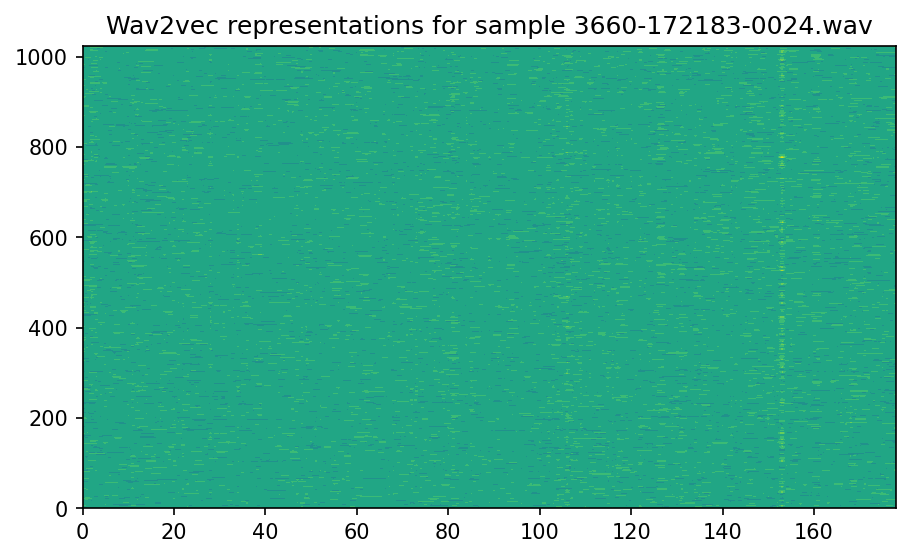

In [10]:
sample_idx = 1
x = np.arange(0, seq_lens[sample_idx])
y = np.arange(0, val_feats.shape[1])
X, Y = np.meshgrid(x, y)
Z = dataset[sample_idx].T
Z = Z / np.sqrt((Z**2).sum(1, keepdims=True))

plt.figure(figsize=(7, 4), dpi=150)
plt.contourf(X, Y, Z, 10)
plt.title(f"Wav2vec representations for sample {audio_ids[sample_idx]}")

In [11]:
cp = '/multirun/2023-05-04/07-33-47/0/w2v2_2023-05-04_07:33:02_2/checkpoint_best.pt'

model, cfg, task = fairseq.checkpoint_utils.load_model_ensemble_and_task([cp])
wav2phn = model[0]
wav2phn.cuda()
wav2phn.eval()

Wav2vec_U(
  (discriminator): Discriminator(
    (net): Sequential(
      (0): Conv1d(44, 384, kernel_size=(8,), stride=(1,), padding=(7,))
      (1): SamePad()
      (2): Dropout(p=0.0, inplace=False)
      (3): Sequential(
        (0): Conv1d(384, 384, kernel_size=(8,), stride=(1,), padding=(7,))
        (1): SamePad()
        (2): Dropout(p=0.0, inplace=False)
        (3): GELU(approximate='none')
      )
      (4): Conv1d(384, 1, kernel_size=(8,), stride=(1,), padding=(7,))
      (5): SamePad()
    )
  )
  (segmenter): JoinSegmenter()
  (generator): Generator(
    (dropout): Dropout(p=0.1, inplace=False)
    (proj): Sequential(
      (0): TransposeLast()
      (1): Conv1d(1024, 44, kernel_size=(9,), stride=(3,), padding=(4,), bias=False)
      (2): TransposeLast()
    )
    (bn): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (in_proj): Linear(in_features=1024, out_features=1024, bias=True)
  )
  (decoder): Linear(in_features=1024, out_feature

In [ ]:
cp = '/multirun/2023-05-21/22-10-47/0/w2v-indy-phn_en-phn_en_2023-05-21_22:08:44_1/checkpoint_best.pt'



In [12]:
cp = '/multirun/2023-05-21/22-10-47/0/w2v-indy-phn_en-phn_en_2023-05-21_22:08:44_1/checkpoint_best.pt'

model, cfg, task = fairseq.checkpoint_utils.load_model_ensemble_and_task([cp], strict=False)
wav2dyn = model[0]
wav2dyn.cuda()
wav2dyn.eval()

LM dict provided. Re-ordering LM embeddings to match with data codes
LM number of parameters: 5.33M


Wav2vec_U(
  (segmenter): JoinSegmenter()
  (ref_lm): GPT(
    (transformer): ModuleDict(
      (wte): Embedding(44, 384)
      (wpe): Embedding(256, 384)
      (drop): Dropout(p=0.2, inplace=False)
      (h): ModuleList(
        (0-2): 3 x Block(
          (ln_1): LayerNorm()
          (attn): CausalSelfAttention(
            (c_attn): Linear(in_features=384, out_features=1152, bias=False)
            (c_proj): Linear(in_features=384, out_features=384, bias=False)
            (attn_dropout): Dropout(p=0.2, inplace=False)
            (resid_dropout): Dropout(p=0.2, inplace=False)
          )
          (ln_2): LayerNorm()
          (mlp): MLP(
            (c_fc): Linear(in_features=384, out_features=1536, bias=False)
            (c_proj): Linear(in_features=1536, out_features=384, bias=False)
            (dropout): Dropout(p=0.2, inplace=False)
          )
        )
      )
      (ln_f): LayerNorm()
    )
    (lm_head): Linear(in_features=384, out_features=44, bias=False)
  )
  (gen_lm)

# Similarity between phone embeddings in reference LM

Cosine similarity

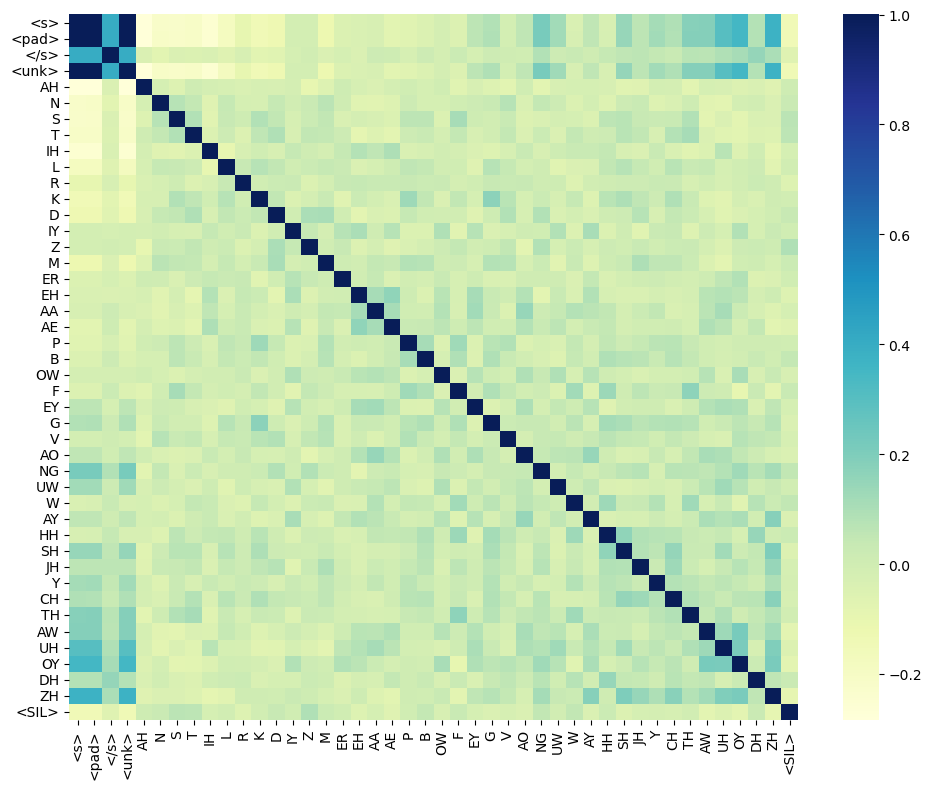

In [13]:
lm_embeddings = wav2dyn.ref_lm.transformer.wte.weight
normalized_tensor = F.normalize(lm_embeddings, p=2, dim=1)
similarity_matrix = torch.matmul(normalized_tensor, normalized_tensor.T)
plt.figure(figsize=(10, 8))
sns.heatmap(similarity_matrix.cpu(), cmap="YlGnBu", 
            yticklabels=task.target_dictionary.symbols, 
            xticklabels=task.target_dictionary.symbols)
plt.tight_layout()
plt.show()

# wav2phn outs

Utterance:
AH N D DH OW DH AW SH OW L D AH S T D IH Z AY ER T UW S IY M AY D IH F IY T AH N D M AY D EH TH B AY DH AH HH AE N D Z AH V DH OW Z M EH N Y EH T D UW AY F IY L N OW D R EH D

Predicted:
AH D DH OW DH AW SH UH D S T IH Z AY ER T UW S IY M AY D IH F IY T IH N M AY D EH TH B AY DH AH HH AE N Z AH V OW Z M EH N D AH N T S Y EH T D UW AY F IY L N OW D R EH D


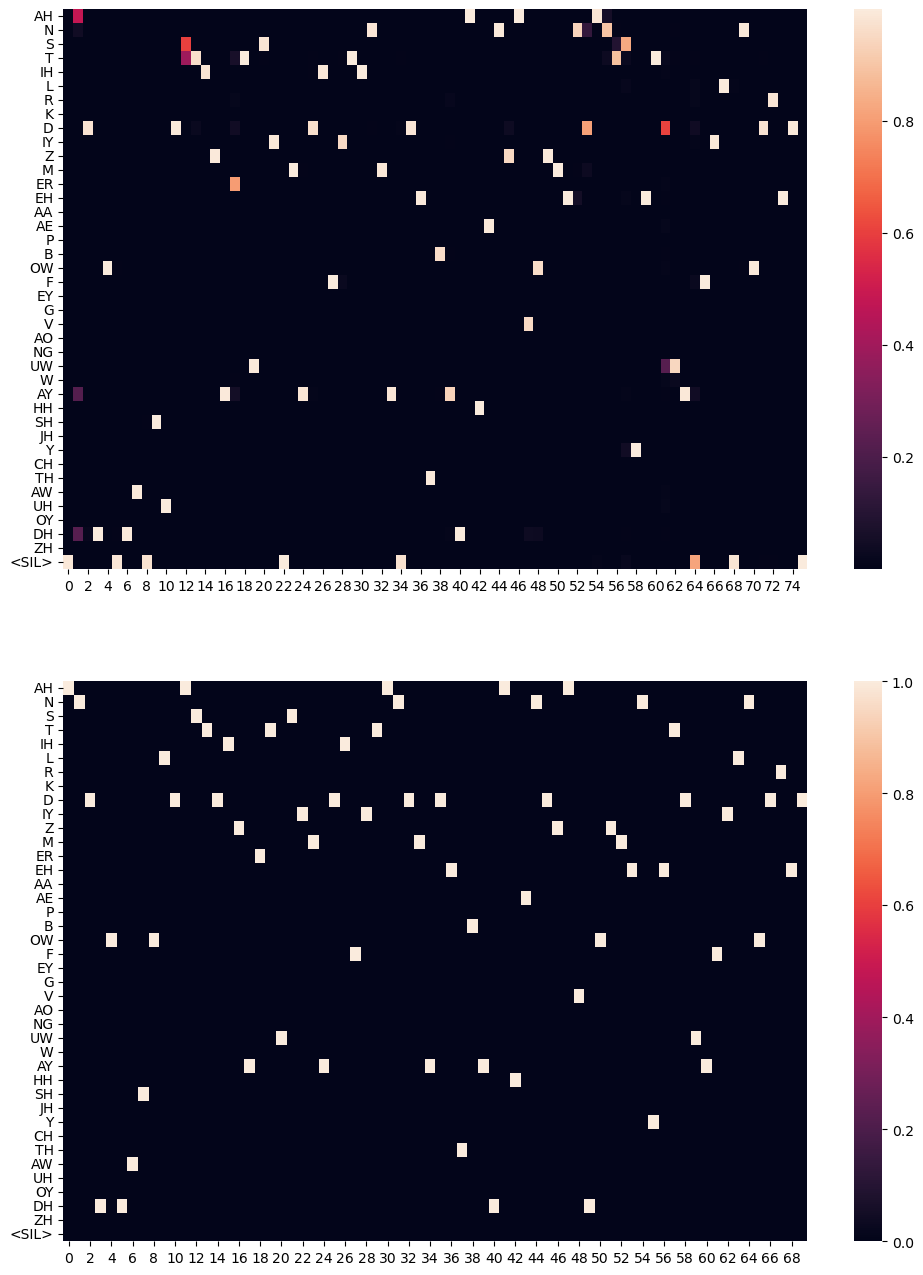

In [11]:
sample_idx = 0
x = torch.FloatTensor(dataset[sample_idx]).unsqueeze(0)
padding_mask = torch.zeros(x.size(0), x.size(1)).bool()
gen_result = wav2phn(x.cuda(), padding_mask.cuda(), dense_x_only=True)
dense_x = gen_result['logits'][:, :, 4:].squeeze().detach().cpu().numpy().T
predicted_x = dense_x.argmax(0) + 4
predicted_x = predicted_x[predicted_x != task.sil_id]
token_x = task.target_dictionary.encode_line(phone_transcripts[sample_idx][:-1], append_eos=False).long() - 4
token_x = F.one_hot(token_x, num_classes=len(task.target_dictionary.symbols) - 4).unsqueeze(0).float().squeeze().detach().numpy().T
plt.figure(figsize=(12, 16))
plt.subplot(211)
sns.heatmap(dense_x, yticklabels=task.target_dictionary.symbols[4:])
plt.subplot(212)
sns.heatmap(token_x, yticklabels=task.target_dictionary.symbols[4:])
print(f"Utterance:\n{phone_transcripts[sample_idx]}")
print(f"Predicted:\n{task.target_dictionary.string(predicted_x)}")

Now LM posteriograms using wav2phn posteriograms as input: 

Utterance:
AH N D DH OW DH AW SH OW L D AH S T D IH Z AY ER T UW S IY M AY D IH F IY T AH N D M AY D EH TH B AY DH AH HH AE N D Z AH V DH OW Z M EH N Y EH T D UW AY F IY L N OW D R EH D

Predicted:
AH D DH OW DH AW SH UH D S T IH Z AY ER T UW S IY M AY D IH F IY T IH N M AY D EH TH B AY DH AH HH AE N Z AH V OW Z M EH N D AH N T S Y EH T D UW AY F IY L N OW D R EH D


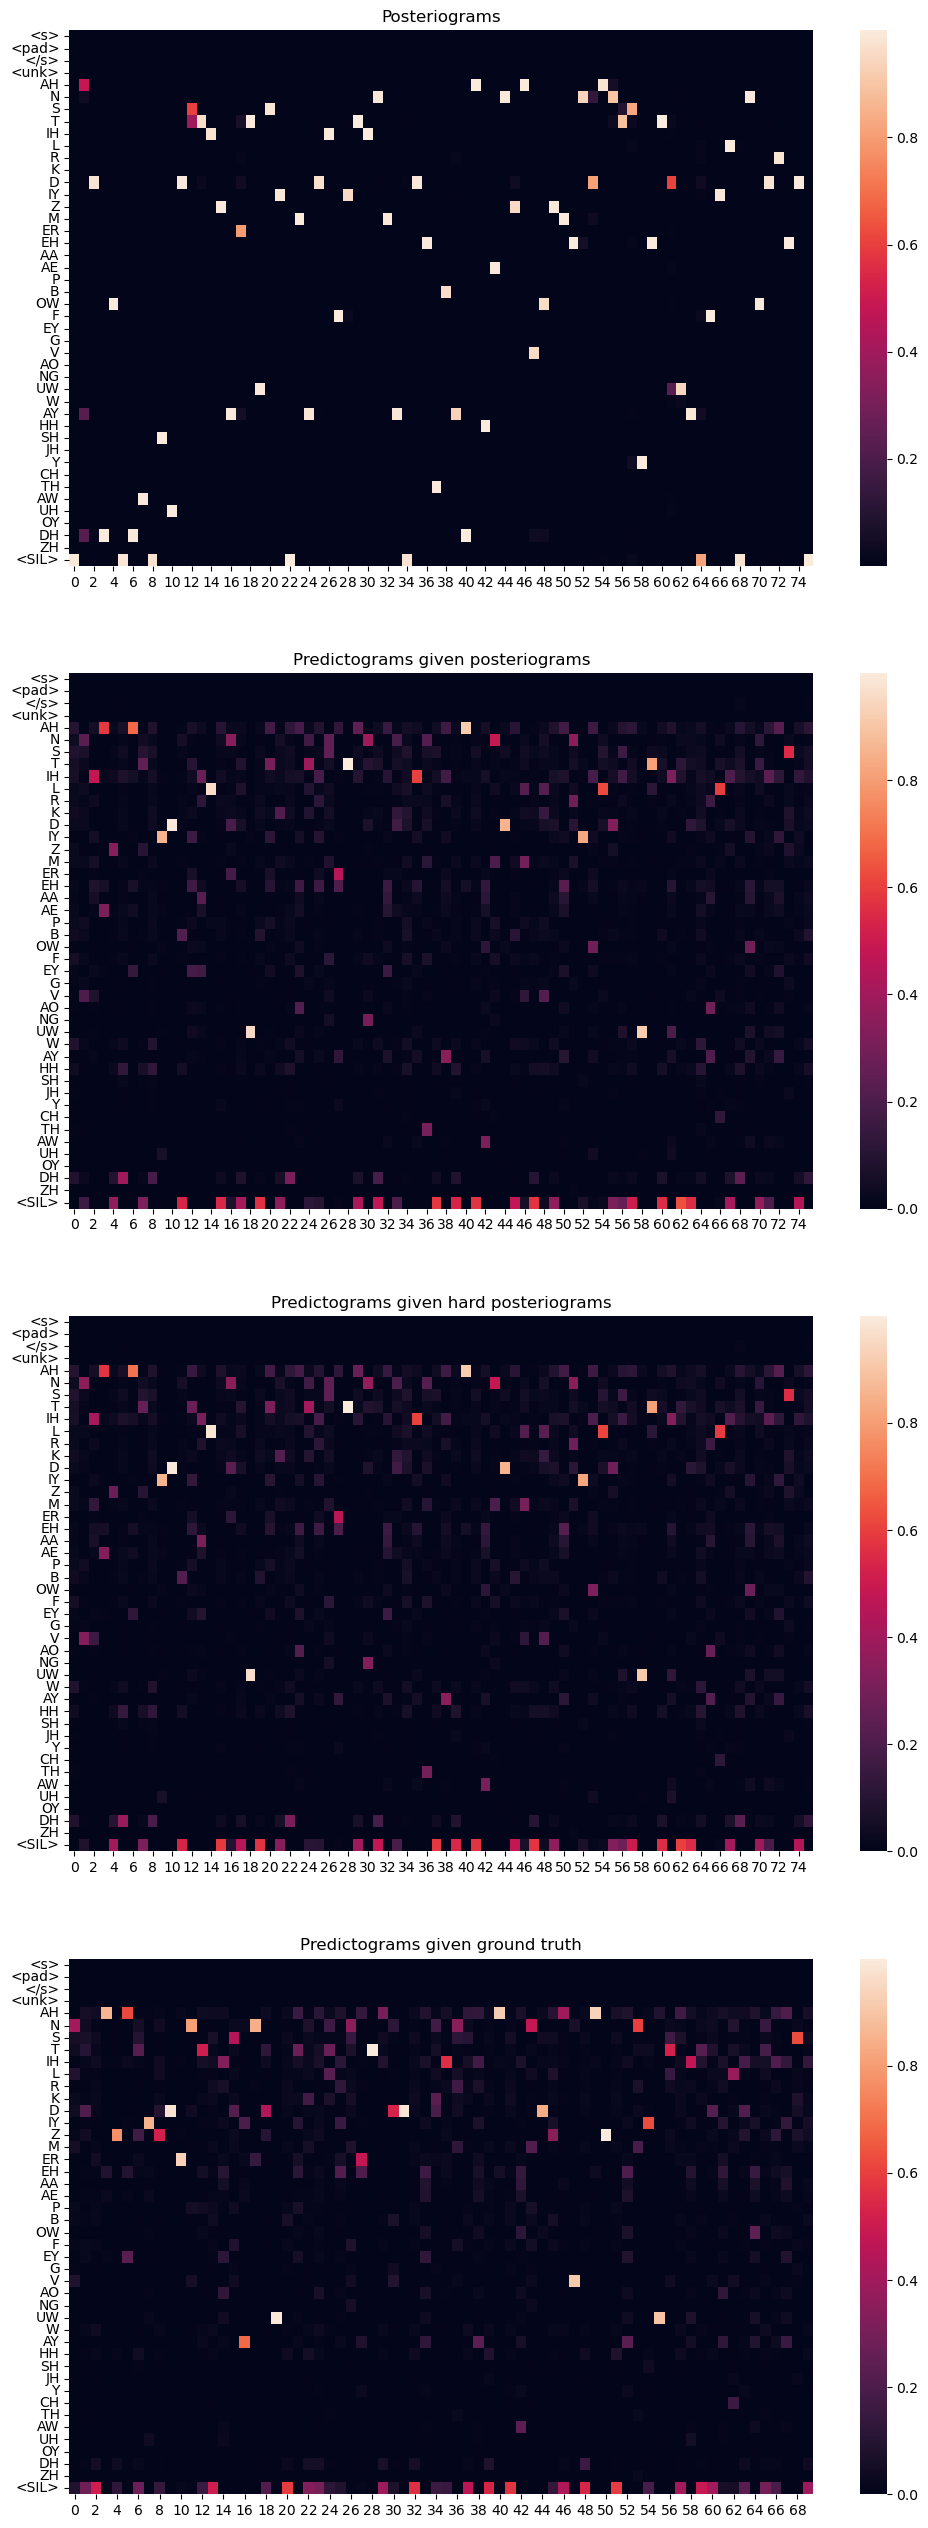

In [12]:
sample_idx = 0
x = torch.FloatTensor(dataset[sample_idx]).unsqueeze(0)
padding_mask = torch.zeros(x.size(0), x.size(1)).bool()
gen_result = wav2phn(x.cuda(), padding_mask.cuda(), dense_x_only=True)
dense_x = gen_result['logits']#[:, :, 4:]
predicted_x = dense_x.argmax(-1)# + 4
predicted_x = predicted_x[predicted_x != task.sil_id]
_, _, lm_post_gen, _ = wav2dyn.ref_lm(dense_x[:, :wav2dyn.block_size, :], return_posteriograms=True)
lm_post_gen = lm_post_gen.squeeze().detach().cpu().numpy().T
token_x = task.target_dictionary.encode_line(phone_transcripts[sample_idx][:-1], append_eos=False).long()# - 4
# token_x = F.one_hot(token_x, num_classes=len(task.target_dictionary.symbols) - 4).unsqueeze(0).float()
token_x = F.one_hot(token_x, num_classes=len(task.target_dictionary.symbols)).unsqueeze(0).float()
_, _, lm_post_true, _ = wav2dyn.ref_lm(token_x[:, :wav2dyn.block_size, :].cuda(), return_posteriograms=True)
lm_post_true = lm_post_true.squeeze().detach().cpu().numpy().T
# token_gen = F.one_hot(dense_x.argmax(-1), num_classes=len(task.target_dictionary.symbols) - 4).float()
token_gen = F.one_hot(dense_x.argmax(-1), num_classes=len(task.target_dictionary.symbols)).float()
_, _, lm_post_gen_hard, _ = wav2dyn.ref_lm(token_gen[:, :wav2dyn.block_size, :], return_posteriograms=True)
lm_post_gen_hard = lm_post_gen_hard.squeeze().detach().cpu().numpy().T
plt.figure(figsize=(12, 32))
plt.subplot(411)
# sns.heatmap(dense_x.squeeze().detach().numpy().T, yticklabels=task.target_dictionary.symbols[4:])
sns.heatmap(dense_x.squeeze().detach().cpu().numpy().T, yticklabels=task.target_dictionary.symbols)
plt.title("Posteriograms")
plt.subplot(412)
# sns.heatmap(lm_post_gen, yticklabels=task.target_dictionary.symbols[4:])
sns.heatmap(lm_post_gen, yticklabels=task.target_dictionary.symbols)
plt.title("Predictograms given posteriograms")
plt.subplot(413)
# sns.heatmap(lm_post_gen_hard, yticklabels=task.target_dictionary.symbols[4:])
sns.heatmap(lm_post_gen_hard, yticklabels=task.target_dictionary.symbols)
plt.title("Predictograms given hard posteriograms")
plt.subplot(414)
# sns.heatmap(lm_post_true, yticklabels=task.target_dictionary.symbols[4:])
sns.heatmap(lm_post_true, yticklabels=task.target_dictionary.symbols)
plt.title("Predictograms given ground truth")
print(f"Utterance:\n{phone_transcripts[sample_idx]}")
print(f"Predicted:\n{task.target_dictionary.string(predicted_x)}")

# wav2dyn outs

Utterance:
AH N D DH OW DH AW SH OW L D AH S T D IH Z AY ER T UW S IY M AY D IH F IY T AH N D M AY D EH TH B AY DH AH HH AE N D Z AH V DH OW Z M EH N Y EH T D UW AY F IY L N OW D R EH D

Predicted:
AE Z W EH W EH S K AW N DH IH T NG S UH K T UW DH AH IH W UH D N AE Z DH AH R IH M W IH V OW K AA Z DH AE Z EH S R DH AH EY AH Z S IH NG R IH Z AE W UH D DH AH R IH CH M


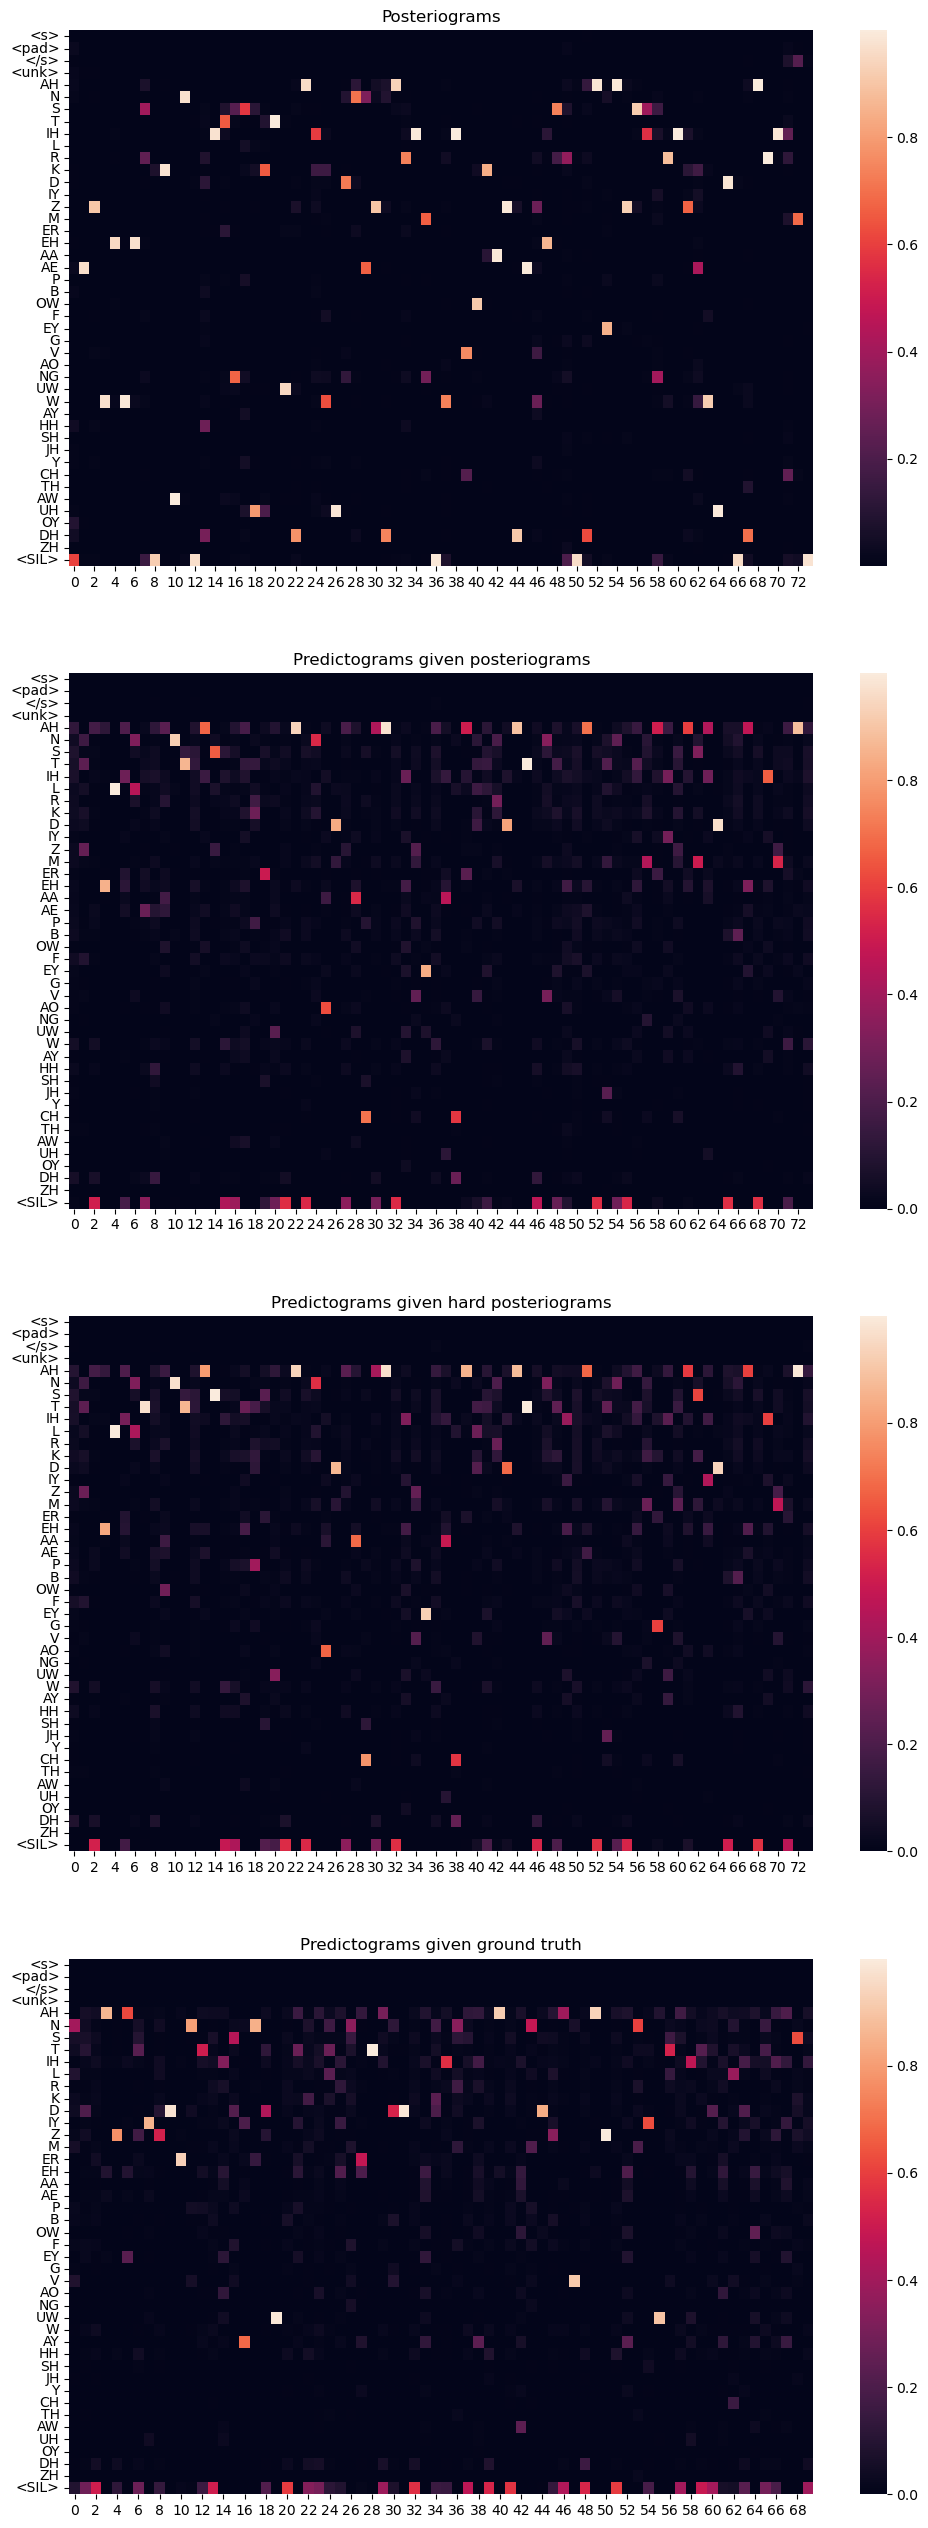

In [13]:
sample_idx = 0
x = torch.FloatTensor(dataset[sample_idx]).unsqueeze(0)
padding_mask = torch.zeros(x.size(0), x.size(1)).bool()
gen_result = wav2dyn(x.cuda(), padding_mask.cuda(), dense_x_only=True)
dense_x = gen_result['logits']#[:, :, 4:]
predicted_x = dense_x.argmax(-1)# + 4
predicted_x = predicted_x[predicted_x != task.sil_id]
_, _, lm_post_gen, _ = wav2dyn.ref_lm(dense_x[:, :wav2dyn.block_size, :])
lm_post_gen = lm_post_gen.squeeze().detach().cpu().numpy().T
token_x = task.target_dictionary.encode_line(phone_transcripts[sample_idx][:-1], append_eos=False).long()# - 4
# token_x = F.one_hot(token_x, num_classes=len(task.target_dictionary.symbols) - 4).unsqueeze(0).float()
token_x = F.one_hot(token_x, num_classes=len(task.target_dictionary.symbols)).unsqueeze(0).float()
_, _, lm_post_true, _ = wav2dyn.ref_lm(token_x[:, :wav2dyn.block_size, :].cuda())
lm_post_true = lm_post_true.squeeze().detach().cpu().numpy().T
# token_gen = F.one_hot(dense_x.argmax(-1), num_classes=len(task.target_dictionary.symbols) - 4).float()
token_gen = F.one_hot(dense_x.argmax(-1), num_classes=len(task.target_dictionary.symbols)).float()
_, _, lm_post_gen_hard, _ = wav2dyn.ref_lm(token_gen[:, :wav2dyn.block_size, :])
lm_post_gen_hard = lm_post_gen_hard.squeeze().detach().cpu().numpy().T
plt.figure(figsize=(12, 32))
plt.subplot(411)
# sns.heatmap(dense_x.squeeze().detach().numpy().T, yticklabels=task.target_dictionary.symbols[4:])
sns.heatmap(dense_x.squeeze().detach().cpu().numpy().T, yticklabels=task.target_dictionary.symbols)
plt.title("Posteriograms")
plt.subplot(412)
# sns.heatmap(lm_post_gen, yticklabels=task.target_dictionary.symbols[4:])
sns.heatmap(lm_post_gen, yticklabels=task.target_dictionary.symbols)
plt.title("Predictograms given posteriograms")
plt.subplot(413)
# sns.heatmap(lm_post_gen_hard, yticklabels=task.target_dictionary.symbols[4:])
sns.heatmap(lm_post_gen_hard, yticklabels=task.target_dictionary.symbols)
plt.title("Predictograms given hard posteriograms")
plt.subplot(414)
# sns.heatmap(lm_post_true, yticklabels=task.target_dictionary.symbols[4:])
sns.heatmap(lm_post_true, yticklabels=task.target_dictionary.symbols)
plt.title("Predictograms given ground truth")
print(f"Utterance:\n{phone_transcripts[sample_idx]}")
print(f"Predicted:\n{task.target_dictionary.string(predicted_x)}")

# Collecting ground truth statistics on wiki40b

In [14]:
from collections import Counter
import re

# Remove newline characters from each string
corpus = [sentence.strip() for sentence in wiki_transcripts]
# Concatenate all the strings in the list into a single string
text = ' '.join(corpus).replace('<SIL>', "")
# Tokenize the string into individual phonemes using regular expressions
tokens = re.findall(r'\b\w+\b|[^\w\s]', text)
# Calculate the frequency distribution of the phonemes
freq_dist = Counter(tokens)
# Print the 10 most common phonemes in the corpus
print(freq_dist.most_common(10))

[('AH', 6266820), ('N', 4825403), ('T', 3619099), ('IH', 3394388), ('R', 2962307), ('S', 2854374), ('D', 2162027), ('L', 2141331), ('K', 1834755), ('IY', 1773248)]


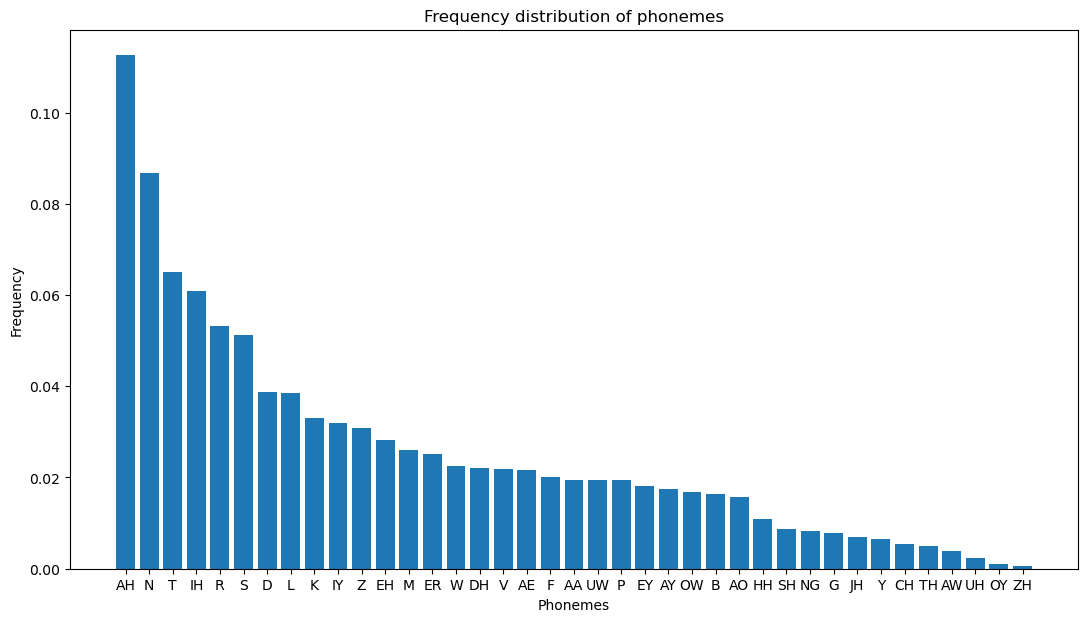

In [15]:
# Sort the frequency distribution in descending order of frequency
sorted_freq_dist = sorted(freq_dist.items(), key=lambda x: x[1], reverse=True)
# Extract the phoneme labels and frequencies into separate lists
labels, frequencies = zip(*sorted_freq_dist)
# Create a bar chart of the frequency distribution of all phonemes
plt.figure(figsize=(13, 7))
plt.bar(labels, frequencies / np.sum(frequencies))
plt.title('Frequency distribution of phonemes')
plt.xlabel('Phonemes')
plt.ylabel('Frequency')
plt.show()

# Collecting ground truth stats on val set

## Unigrams

In [14]:
from collections import Counter
import re

# Remove newline characters from each string
corpus = [sentence.strip() for sentence in phone_transcripts]
# Concatenate all the strings in the list into a single string
text = ' '.join(corpus)
# Tokenize the string into individual phonemes using regular expressions
tokens = re.findall(r'\b\w+\b|[^\w\s]', text)
# Calculate the frequency distribution of the phonemes
freq_dist = Counter(tokens)
# Print the 10 most common phonemes in the corpus
print(freq_dist.most_common(10))

[('AH', 17549), ('N', 12816), ('T', 12657), ('IH', 10532), ('D', 9316), ('S', 8822), ('R', 7659), ('L', 7019), ('IY', 6298), ('DH', 5663)]


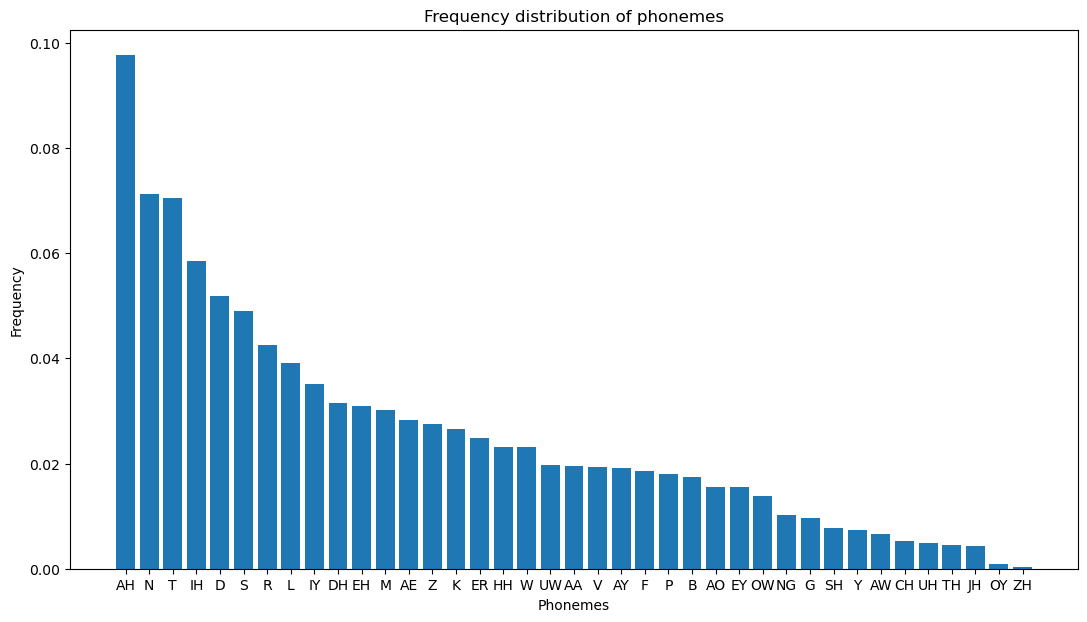

In [15]:
# Sort the frequency distribution in descending order of frequency
sorted_freq_dist = sorted(freq_dist.items(), key=lambda x: x[1], reverse=True)
# Extract the phoneme labels and frequencies into separate lists
labels, frequencies = zip(*sorted_freq_dist)
# Create a bar chart of the frequency distribution of all phonemes
plt.figure(figsize=(13, 7))
plt.bar(labels, frequencies / np.sum(frequencies))
plt.title('Frequency distribution of phonemes')
plt.xlabel('Phonemes')
plt.ylabel('Frequency')
plt.show()

## LM n-grams

In [18]:
posteriograms = []

for transcript in tqdm(phone_transcripts):
#     token_x = task.target_dictionary.encode_line(transcript[:-1], append_eos=False).long() - 4
    token_x = task.target_dictionary.encode_line(transcript[:-1], append_eos=False).long()
#     token_x = F.one_hot(token_x, num_classes=len(task.target_dictionary.symbols) - 4).unsqueeze(0).float()
    token_x = F.one_hot(token_x, num_classes=len(task.target_dictionary.symbols)).unsqueeze(0).float()
    _, _, lm_post_true, _ = wav2dyn.ref_lm(token_x[:, :wav2dyn.block_size, :].cuda())
    lm_post_true = lm_post_true.squeeze().detach().cpu().numpy()
    posteriograms.append(lm_post_true)

  0%|          | 0/2864 [00:00<?, ?it/s]

In [19]:
posteriograms = np.vstack(posteriograms)
unigram_probs = posteriograms.mean(0)[:-1]
# syms = task.target_dictionary.symbols[4:-1]
syms = task.target_dictionary.symbols[:-1]
freq_dist = {syms[i]: p for i, p in enumerate(unigram_probs)}
sorted_probs = [freq_dist[label] for label in labels]

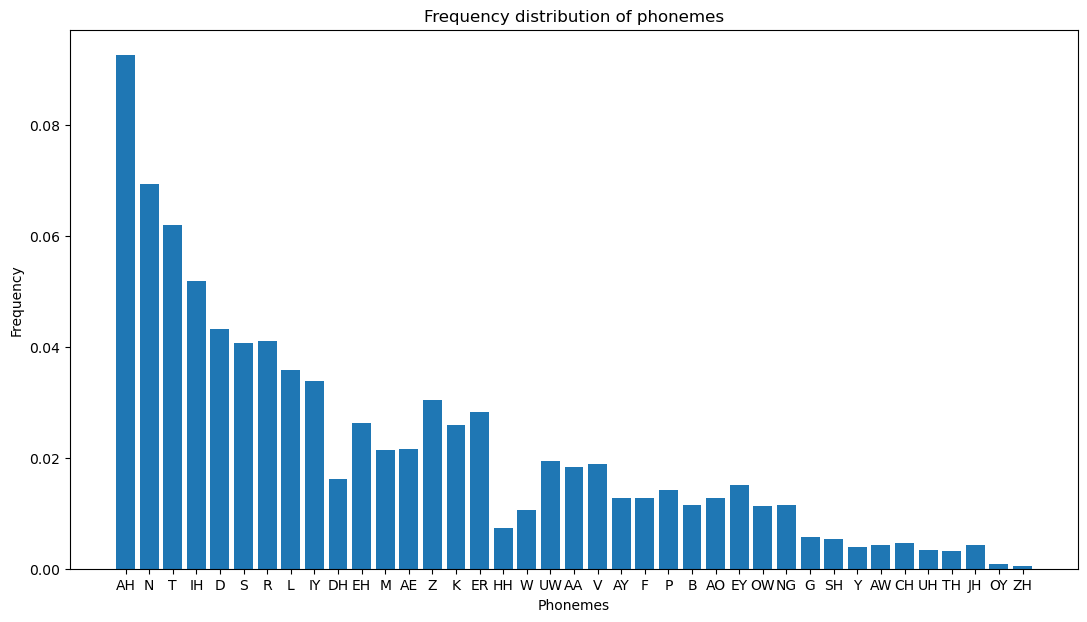

In [20]:
plt.figure(figsize=(13, 7))
plt.bar(labels, sorted_probs)
plt.title('Frequency distribution of phonemes')
plt.xlabel('Phonemes')
plt.ylabel('Frequency')
plt.show()

# Collecting stats on wav2phn after 2000 updates

In [21]:
posteriograms = []

for sample in tqdm(dataset):
    x = torch.FloatTensor(sample).unsqueeze(0)
    padding_mask = torch.zeros(x.size(0), x.size(1)).bool()
    gen_result = wav2phn(x.cuda(), padding_mask.cuda(), dense_x_only=True)
#     dense_x = gen_result['logits'][:, :, 4:].squeeze().detach().numpy()
    dense_x = gen_result['logits'].squeeze().detach().cpu().numpy()
    posteriograms.append(dense_x)

  0%|          | 0/2864 [00:00<?, ?it/s]

In [22]:
posteriograms = np.vstack(posteriograms)
unigram_probs = posteriograms.mean(0)[:-1]
# syms = task.target_dictionary.symbols[4:-1]
syms = task.target_dictionary.symbols[:-1]
freq_dist = {syms[i]: p for i, p in enumerate(unigram_probs)}
sorted_probs = [freq_dist[label] for label in labels]

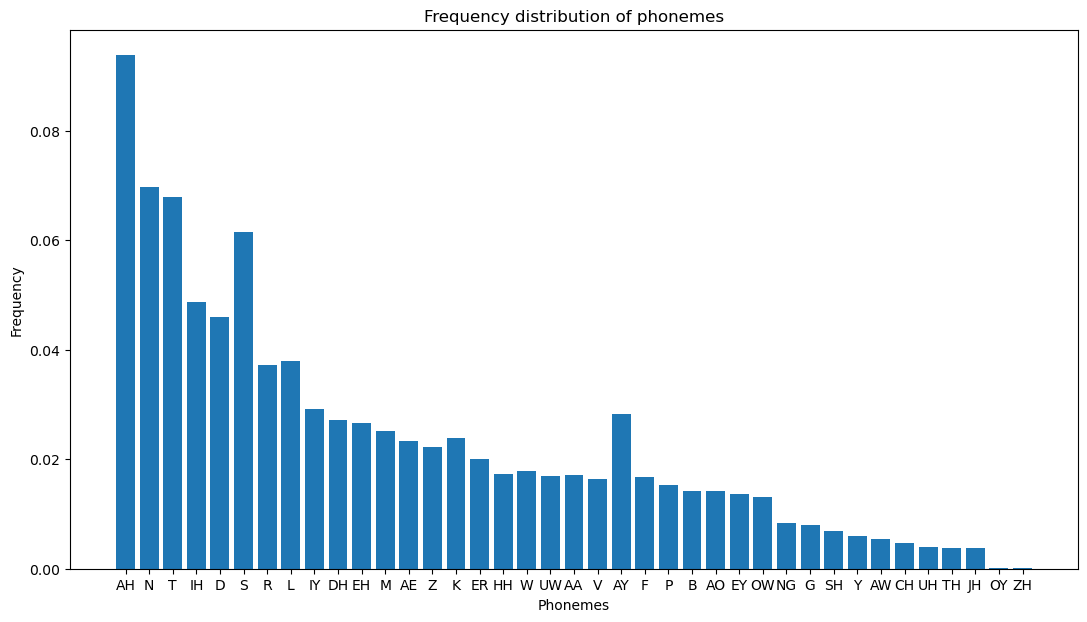

In [23]:
plt.figure(figsize=(13, 7))
plt.bar(labels, sorted_probs)
plt.title('Frequency distribution of phonemes')
plt.xlabel('Phonemes')
plt.ylabel('Frequency')
plt.show()

# Collecting stats on best wav2dyn after whole training

## On unigram posteriograms

In [24]:
posteriograms = []

for sample in tqdm(dataset):
    x = torch.FloatTensor(sample).unsqueeze(0)
    padding_mask = torch.zeros(x.size(0), x.size(1)).bool()
    gen_result = wav2dyn(x.cuda(), padding_mask.cuda(), dense_x_only=True)
#     dense_x = gen_result['logits'][:, :, 4:].squeeze().detach().numpy()
    dense_x = gen_result['logits'].squeeze().detach().cpu().numpy()
    posteriograms.append(dense_x)

  0%|          | 0/2864 [00:00<?, ?it/s]

In [25]:
posteriograms = np.vstack(posteriograms)
unigram_probs = posteriograms.mean(0)[:-1]
# syms = task.target_dictionary.symbols[4:-1]
syms = task.target_dictionary.symbols[:-1]
freq_dist = {syms[i]: p for i, p in enumerate(unigram_probs)}
sorted_probs = [freq_dist[label] for label in labels]

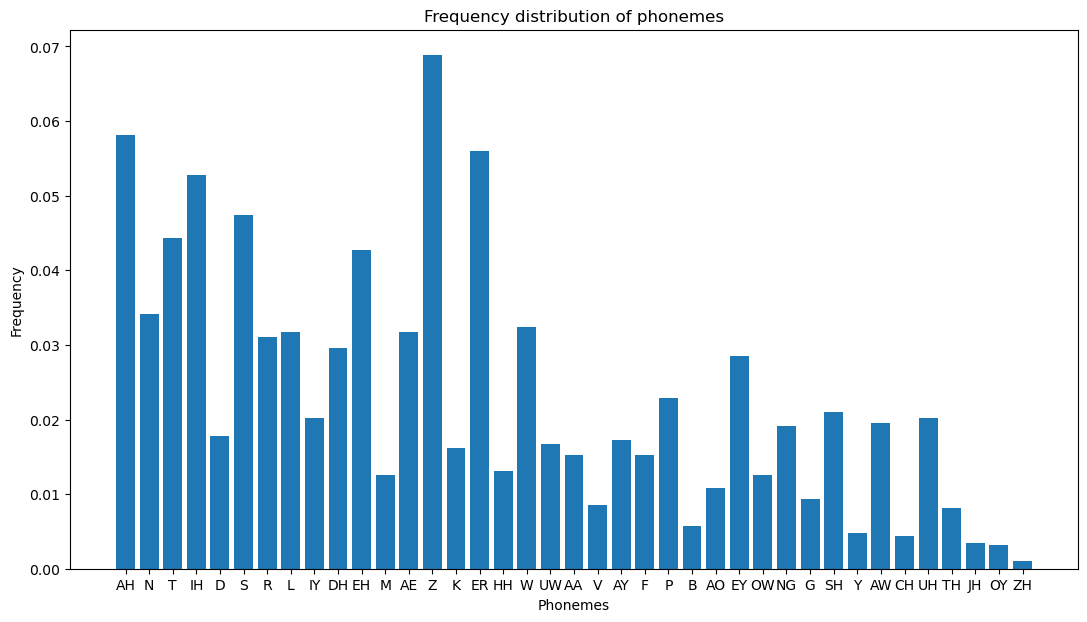

In [26]:
plt.figure(figsize=(13, 7))
plt.bar(labels, sorted_probs)
plt.title('Frequency distribution of phonemes')
plt.xlabel('Phonemes')
plt.ylabel('Frequency')
plt.show()

## On LM n-gram posteriograms

In [27]:
posteriograms = []

for sample in tqdm(dataset):
    x = torch.FloatTensor(sample).unsqueeze(0)
    padding_mask = torch.zeros(x.size(0), x.size(1)).bool()
    gen_result = wav2dyn(x.cuda(), padding_mask.cuda(), dense_x_only=True)
    dense_x = gen_result['logits']
    _, _, lm_post_gen, _ = wav2dyn.ref_lm(dense_x[:, :wav2dyn.block_size, :])
    lm_post_gen = lm_post_gen.squeeze().detach().cpu().numpy()
    posteriograms.append(lm_post_gen)

  0%|          | 0/2864 [00:00<?, ?it/s]

In [28]:
posteriograms = np.vstack(posteriograms)
unigram_probs = posteriograms.mean(0)[:-1]
# syms = task.target_dictionary.symbols[4:-1]
syms = task.target_dictionary.symbols[:-1]
freq_dist = {syms[i]: p for i, p in enumerate(unigram_probs)}
sorted_probs = [freq_dist[label] for label in labels]

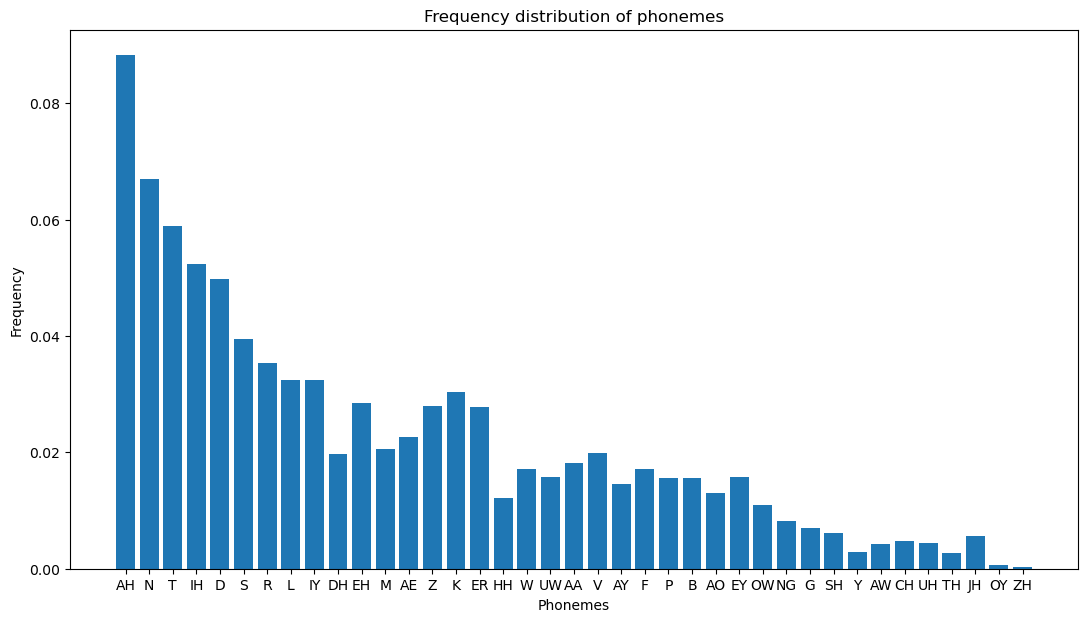

In [29]:
plt.figure(figsize=(13, 7))
plt.bar(labels, sorted_probs)
plt.title('Frequency distribution of phonemes')
plt.xlabel('Phonemes')
plt.ylabel('Frequency')
plt.show()

# Collecting stats for random input sequences to LM

In [30]:
posteriograms = []

for transcript in tqdm(phone_transcripts):
    seq_len = random.randint(31, 128)
    token_x = torch.randint(0, len(task.target_dictionary.symbols), (seq_len,))
    token_x = F.one_hot(token_x, num_classes=len(task.target_dictionary.symbols)).unsqueeze(0).float()
    _, _, lm_post_true, _ = wav2dyn.ref_lm(token_x[:, :wav2dyn.block_size, :].cuda())
    lm_post_true = lm_post_true.squeeze().detach().cpu().numpy()
    posteriograms.append(lm_post_true)

  0%|          | 0/2864 [00:00<?, ?it/s]

In [31]:
posteriograms = np.vstack(posteriograms)
unigram_probs = posteriograms.mean(0)[:-1]
# syms = task.target_dictionary.symbols[4:-1]
syms = task.target_dictionary.symbols[:-1]
freq_dist = {syms[i]: p for i, p in enumerate(unigram_probs)}
sorted_probs = [freq_dist[label] for label in labels]

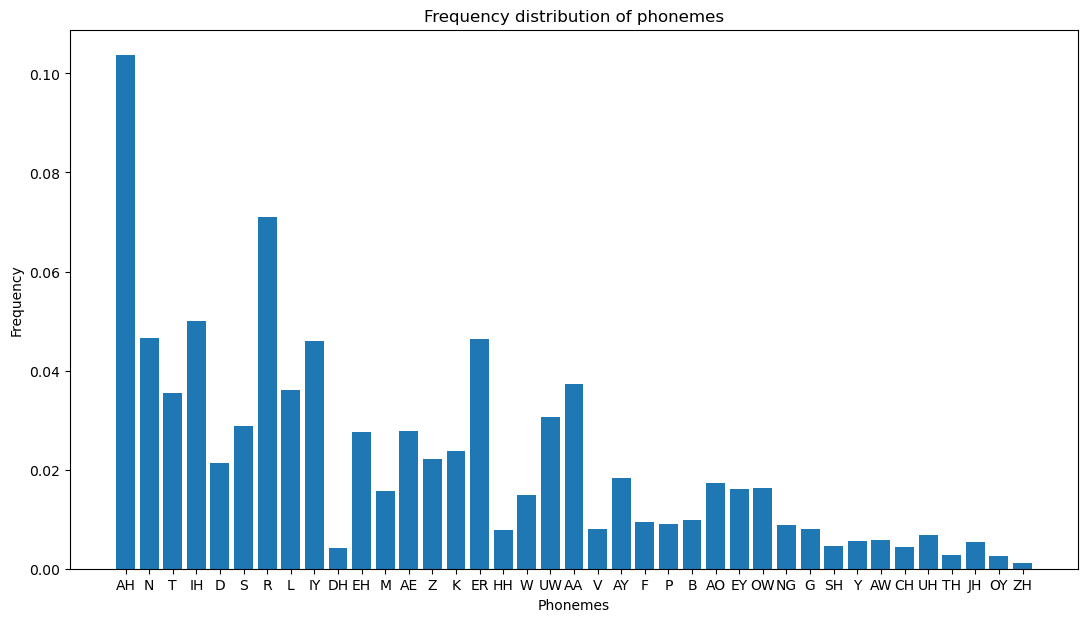

In [32]:
plt.figure(figsize=(13, 7))
plt.bar(labels, sorted_probs)
plt.title('Frequency distribution of phonemes')
plt.xlabel('Phonemes')
plt.ylabel('Frequency')
plt.show()

# Comparing LM predictograms on wav2dyn predictions vs. on phone transcriptions

In [14]:
lm_ckpt = "/home/santiago.cuervo/ssl/nanoGPT/out-librispeech-phn/en/ckpt.pt"
data_path = '/home/santiago.cuervo/data/fairseqProcessed/LibriSpeech-no-silence/'
text_data = '/home/santiago.cuervo/data/fairseqProcessed/LibriSpeech-txt/phones'
out_dir = ''
learning_rate = 3e-4
beta1 = 0.5
beta2 = 0.98
batch_size = 160
eval_interval = 100
eval_iters = 3
log_interval = 10
max_iters = 10000
lr_decay_iters = 10000
warmup_iters = 2000
min_lr = 6e-5
device = 'cuda'
dtype = 'float32'
grad_clip = 1.0
target_dict = task._target_dictionary

In [12]:
tunable_gen_lm_layers = -2

# Load GPT model and encoder
checkpoint = torch.load(lm_ckpt) # , map_location=p.device)
if os.path.isfile(os.path.join(os.path.dirname(lm_ckpt), "dict.txt")):
    print("LM dict provided. Re-ordering LM embeddings to match with data codes")
    with open(os.path.join(os.path.dirname(lm_ckpt), "dict.txt"), "r") as f:
        lm_vocab = [x.split()[0] for x in f]
    assert set(lm_vocab) == set(target_dict.symbols), "The task and LM vocabularies don't match"
    # Sort list2 using list1 as a key
    sorted_list2 = sorted(lm_vocab, key=lambda x: target_dict.symbols.index(x))
    # Get the indices that would sort list2 to be the same as list1
    indices = [lm_vocab.index(x) for x in sorted_list2]
gptconf = GPTConfig(**checkpoint['model_args'])
state_dict = checkpoint['model']
# Re-arrange embeddings and output units so that the task codes will match the embeddings codes
state_dict["transformer.wte.weight"] = state_dict["transformer.wte.weight"][indices]
state_dict["lm_head.weight.weight"] = state_dict["lm_head.weight"][indices]
model = GPT(gptconf)
model.load_state_dict(state_dict)
if tunable_gen_lm_layers < 0:  # Tune specific layers 
    # Tune only ln_f (lm_head is not tuned as it shares weights with the token embeddings)
    for name, param in model.named_parameters():
        if name not in ["transformer.ln_f.weight", "transformer.ln_f.bias"]:
            param.requires_grad = False
    # Make the specified transformer blocks trainable
    n_blocks_to_update = min(abs(tunable_gen_lm_layers + 1), len(model.transformer.h))
    if n_blocks_to_update > 0:
        for i, block in enumerate(model.transformer.h[::-1]):
            if i < n_blocks_to_update:
                for param in block.parameters():
                    param.requires_grad = True
model.cuda()

checkpoint_model_args = checkpoint['model_args']
model_args = {}
for k in ['n_layer', 'n_head', 'n_embd', 'block_size', 'bias', 'vocab_size']:
    model_args[k] = checkpoint_model_args[k]

LM dict provided. Re-ordering LM embeddings to match with data codes
LM number of parameters: 5.33M


In [15]:
def prepare_dataset(split):
    has_unpaired_text = os.path.exists(os.path.join(text_data, f"{split}.idx"))
    dataset = ExtractedFeaturesDataset(
        path=data_path,
        split=split,
        min_length=3,
        max_length=256,
        labels=None if has_unpaired_text else 'phn',
        label_dict=target_dict,
        shuffle=True
    )
    if has_unpaired_text:
        text_dataset = data_utils.load_indexed_dataset(os.path.join(text_data, split), target_dict)
        text_dataset = StripTokenDataset(text_dataset, target_dict.eos())
        dataset = RandomInputDataset(
            dataset,
            text_dataset,
            ["random_label"],
            add_to_input=True,
            pad_idx=target_dict.pad(),
        )
    return dataset

In [16]:
train_data = prepare_dataset('train')
val_data = prepare_dataset('valid')

2023-05-25 21:04:42 | INFO | data.extracted_features_dataset | loaded 2641, skipped 0 samples
2023-05-25 21:04:42 | INFO | fairseq.data.data_utils | loaded 2,400,103 examples from: /home/santiago.cuervo/data/fairseqProcessed/LibriSpeech-txt/phones/train
2023-05-25 21:04:42 | INFO | data.extracted_features_dataset | loaded 1703, skipped 0 samples


In [17]:
ptdtype = {'float32': torch.float32, 'bfloat16': torch.bfloat16, 'float16': torch.float16}[dtype]
ctx = torch.amp.autocast(device_type=device, dtype=ptdtype)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, betas=(beta1, beta2))

AttributeError: 'list' object has no attribute 'parameters'

In [18]:
# learning rate decay scheduler (cosine with warmup)
def get_lr(it):
    # 1) linear warmup for warmup_iters steps
    if it < warmup_iters:
        return learning_rate * it / warmup_iters
    # 2) if it > lr_decay_iters, return min learning rate
    if it > lr_decay_iters:
        return min_lr
    # 3) in between, use cosine decay down to min learning rate
    decay_ratio = (it - warmup_iters) / (lr_decay_iters - warmup_iters)
    assert 0 <= decay_ratio <= 1
    coeff = 0.5 * (1.0 + math.cos(math.pi * decay_ratio)) # coeff ranges 0..1
    return min_lr + coeff * (learning_rate - min_lr)

def get_batch(itr):
    net_in = next(itr)['net_input']
    x, mask = net_in['features'], net_in['padding_mask']
    x, mask = x.to(device), mask.to(device)
    y = None
    if 'random_label' in net_in:
        y = net_in['random_label']
        y = y.to(device)
    gen_result = wav2dyn(x, mask, y, dense_x_only=True)
    x = gen_result["logits"]
    mask = gen_result["padding_mask"]
    y = x.argmax(dim=-1)[:, 1:].long()
    x = x[:, :-1]
    mask = mask[:, :-1]
    return x, y, mask

# helps estimate an arbitrarily accurate loss over either split using many batches
@torch.no_grad()
def estimate_loss(train_itr, val_itr):
    out = {}
    model.eval()
    for split, itr in zip(['train', 'val'], [train_itr, val_itr]):
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y, mask = get_batch(itr)
            with ctx:
                _, logits, _, _ = model(X, return_logits=True)
            loss = F.cross_entropy(logits.reshape(-1, logits.size(-1)), Y.reshape(-1), reduction="none")
            loss = loss[~mask.reshape(-1)].mean()
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

In [19]:
def get_batch_iterator(split, epoch):
    batch_iterator = task.get_batch_iterator(
        dataset=train_data if split == 'train' else val_data,
        max_sentences=batch_size,
        ignore_invalid_inputs=True,
        seed=0 + epoch,
        num_workers=2,
        epoch=epoch
    )
    dummy_batch = batch_iterator.first_batch
    itr = batch_iterator.next_epoch_itr(shuffle=True if split == 'train' else False)
    return itr

In [59]:
# wandb.init(project='w2v-u-indy', name=f'babygpt-on-posterio-LM[{tunable_gen_lm_layers}]', entity='indy-lis')
# out_dir = 'lm_on_wav2dyn_out'
# os.makedirs(out_dir, exist_ok=True)

# iter_num = 0
# best_val_loss = 1e9
# epoch = 1

# # training loop
# train_itr = get_batch_iterator('train', epoch)
# X, Y, mask = get_batch(train_itr) # fetch the very first batch
# while True:
#     # determine and set the learning rate for this iteration
#     lr = get_lr(iter_num)
#     for param_group in optimizer.param_groups:
#         param_group['lr'] = lr
#     with ctx:
#         _, logits, _, _ = model(X, return_logits=True)
#     loss = F.cross_entropy(logits.reshape(-1, logits.size(-1)), Y.reshape(-1), reduction="none")
#     loss = loss[~mask.reshape(-1)].mean()            
#     # backward pass, with gradient scaling if training in fp16
#     loss.backward()
#     torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
#     optimizer.step()
#     optimizer.zero_grad(set_to_none=True)

#     if iter_num % log_interval == 0:
#         lossf = loss.item() # loss as float. note: this is a CPU-GPU sync point
#         print(f"iter {iter_num}: loss {lossf:.4f}")
#     iter_num += 1

#     # termination conditions
#     if iter_num > max_iters:
#         break
#     try:
#         X, Y, mask = get_batch(train_itr)
#     except StopIteration:
#         # evaluate the loss on train/val sets and write checkpoints
#         train_itr = get_batch_iterator('train', epoch)
#         val_itr = get_batch_iterator('val', epoch)
#         losses = estimate_loss(train_itr, val_itr)
#         print(f"step {iter_num}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")
#         wandb.log({
#             "iter": iter_num,
#             "train/loss": losses['train'],
#             "val/loss": losses['val'],
#             "lr": lr            })
#         if losses['val'] < best_val_loss:
#             best_val_loss = losses['val']
#             if iter_num > 0:
#                 checkpoint = {
#                     'model': model.state_dict(),
#                     'optimizer': optimizer.state_dict(),
#                     'model_args': model_args,
#                     'iter_num': iter_num,
#                     'best_val_loss': best_val_loss,
# #                     'config': config,
#                 }
#                 print(f"saving checkpoint to {out_dir}")
#                 torch.save(checkpoint, os.path.join(out_dir, f'gpt-on-probs-l_{tunable_gen_lm_layers}.pt'))
#         epoch += 1
#         train_itr = get_batch_iterator('train', epoch)
#         X, Y, mask = get_batch(train_itr)
# wandb.finish()

# Comparing predictograms from frozen LM on wav2phn and wav2dyn posteriograms:

In [60]:
lm_ckpt = "/home/santiago.cuervo/ssl/nanoGPT/out-librispeech-phn/en/ckpt.pt"
# Load GPT model and encoder
checkpoint = torch.load(lm_ckpt) # , map_location=p.device)
if os.path.isfile(os.path.join(os.path.dirname(lm_ckpt), "dict.txt")):
    print("LM dict provided. Re-ordering LM embeddings to match with data codes")
    with open(os.path.join(os.path.dirname(lm_ckpt), "dict.txt"), "r") as f:
        lm_vocab = [x.split()[0] for x in f]
    assert set(lm_vocab) == set(target_dict.symbols), "The task and LM vocabularies don't match"
    # Sort list2 using list1 as a key
    sorted_list2 = sorted(lm_vocab, key=lambda x: target_dict.symbols.index(x))
    # Get the indices that would sort list2 to be the same as list1
    indices = [lm_vocab.index(x) for x in sorted_list2]
gptconf = GPTConfig(**checkpoint['model_args'])
state_dict = checkpoint['model']
# Re-arrange embeddings and output units so that the task codes will match the embeddings codes
state_dict["transformer.wte.weight"] = state_dict["transformer.wte.weight"][indices]
state_dict["lm_head.weight.weight"] = state_dict["lm_head.weight"][indices]
model = GPT(gptconf)
model.load_state_dict(state_dict)
model.eval()
model.cuda()

LM dict provided. Re-ordering LM embeddings to match with data codes
LM number of parameters: 5.33M


GPT(
  (transformer): ModuleDict(
    (wte): Embedding(44, 384)
    (wpe): Embedding(256, 384)
    (drop): Dropout(p=0.2, inplace=False)
    (h): ModuleList(
      (0-2): 3 x Block(
        (ln_1): LayerNorm()
        (attn): CausalSelfAttention(
          (c_attn): Linear(in_features=384, out_features=1152, bias=False)
          (c_proj): Linear(in_features=384, out_features=384, bias=False)
          (attn_dropout): Dropout(p=0.2, inplace=False)
          (resid_dropout): Dropout(p=0.2, inplace=False)
        )
        (ln_2): LayerNorm()
        (mlp): MLP(
          (c_fc): Linear(in_features=384, out_features=1536, bias=False)
          (c_proj): Linear(in_features=1536, out_features=384, bias=False)
          (dropout): Dropout(p=0.2, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm()
  )
  (lm_head): Linear(in_features=384, out_features=44, bias=False)
)

In [61]:
def get_batch(itr, predictor):
    net_in = next(itr)['net_input']
    x, mask = net_in['features'], net_in['padding_mask']
    x, mask = x.to(device), mask.to(device)
    y = None
    if 'random_label' in net_in:
        y = net_in['random_label']
        y = y.to(device)
    gen_result = predictor(x, mask, y, dense_x_only=True)
    x = gen_result["logits"]
    mask = gen_result["padding_mask"]
#     y = x.argmax(dim=-1)[:, 1:].long()
    x = x[:, :-1]
    mask = mask[:, :-1]
    return x, y, mask

In [62]:
def select_non_padding_elements(input_tensor, mask):
    # Get the dimensions
    B, T, D = input_tensor.size()
    # Reshape the input tensor and mask to combine the batch and time dimensions
    reshaped_input = input_tensor.view(-1, D)
    reshaped_mask = mask.contiguous().view(-1)
    # Get the indices of non-padding elements
    indices = torch.nonzero(~reshaped_mask).squeeze()
    # Select the non-padding elements from the reshaped input tensor
    selected_elements = reshaped_input[indices]
    # Reshape the selected elements tensor to the original format
    N = selected_elements.size(0)
    selected_elements = selected_elements.view(N, D)
    return selected_elements

def get_unpadded_sequences(input_tensor, mask):
    # Get the dimensions
    B, T, D = input_tensor.size()
    # Create an empty list to store the unpadded sequences
    sequences = []
    # Iterate over the batches
    for b in range(B):
        # Get the mask for the current batch
        batch_mask = mask[b]
        # Get the indices of non-padding elements
        indices = torch.nonzero(~batch_mask).squeeze()
        # Select the non-padding elements from the input tensor
        selected_elements = input_tensor[b, indices]
        # Append the selected elements to the list
        sequences.append(selected_elements)
    return sequences

In [63]:
predictograms_w2d = []
predictograms_w2p = []
predictograms_gt = []
# training loop
train_itr_w2d = get_batch_iterator('train', epoch=1)
train_itr_w2p = get_batch_iterator('train', epoch=1)
X_w2d, Y_w2d, mask_w2d = get_batch(train_itr_w2d, wav2dyn)
X_w2p, Y_w2p, mask_w2p = get_batch(train_itr_w2p, wav2phn)
while True:
    with torch.no_grad():
        mask_gt = (Y_w2d == wav2dyn.pad)[:, :wav2dyn.block_size]
        X_gt = F.one_hot(Y_w2d, num_classes=len(task.target_dictionary.symbols))[:, :wav2dyn.block_size].float()
        _, _, probs_w2d, _ = model(X_w2d, return_posteriograms=True)
        _, _, probs_w2p, _ = model(X_w2p, return_posteriograms=True)
        _, _, probs_gt, _ = model(X_gt, return_posteriograms=True)
#         predictograms_w2d.append(select_non_padding_elements(probs_w2d, mask_w2d))
#         predictograms_w2p.append(select_non_padding_elements(probs_w2p, mask_w2p))
        predictograms_w2d += get_unpadded_sequences(probs_w2d, mask_w2d)
        predictograms_w2p += get_unpadded_sequences(probs_w2p, mask_w2p)
        predictograms_gt += get_unpadded_sequences(probs_gt, mask_gt)
    try:
        X_w2d, Y_w2d, mask_w2d = get_batch(train_itr_w2d, wav2dyn)
        X_w2p, Y_w2p, mask_w2p = get_batch(train_itr_w2p, wav2phn)
    except StopIteration:
#         predictograms_w2d = torch.vstack(predictograms_w2d)
#         predictograms_w2p = torch.vstack(predictograms_w2p)
        break

In [64]:
def plot_heatmap_grid(sequences):
    # Randomly select 12 sequences
    selected_sequences = random.sample(sequences, k=12)
    # Create a 4x3 grid of subplots for heatmaps
    fig, axes = plt.subplots(4, 3, figsize=(48, 36))
    # Flatten the axes array for easier iteration
    axes = axes.flatten()
    # Iterate over the selected sequences and plot heatmaps
    for i, sequence in enumerate(selected_sequences):
        # Create a heatmap for the current sequence
        sns.heatmap(sequence.squeeze().cpu().numpy().T, ax=axes[i], yticklabels=task.target_dictionary.symbols)
        axes[i].set_title(f"Sequence {i+1}")
    # Remove any remaining empty subplots
    if len(selected_sequences) < len(axes):
        for j in range(len(selected_sequences), len(axes)):
            fig.delaxes(axes[j])
    # Adjust the layout and spacing of subplots
    plt.tight_layout()
    # Show the plot
    plt.show()

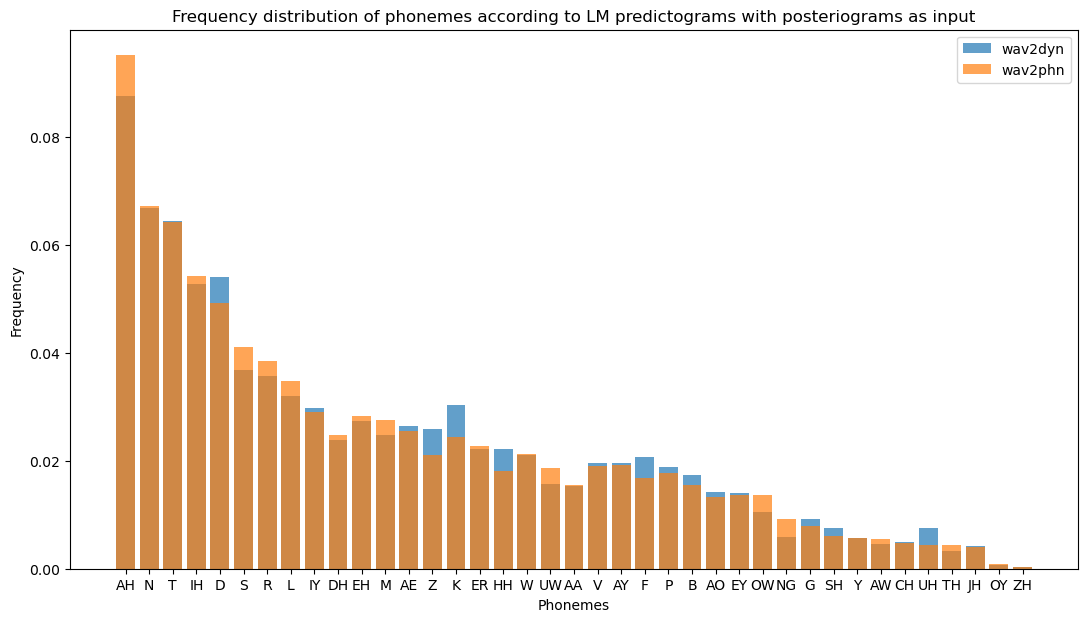

In [71]:
# For wav2dyn
probs = torch.vstack(predictograms_w2d)
unigram_probs = probs.mean(0)[:-1]
syms = task.target_dictionary.symbols[:-1]
freq_dist = {syms[i]: p for i, p in enumerate(unigram_probs)}
sorted_probs_w2d = [freq_dist[label].cpu() for label in labels]
# For wav2phn
probs = torch.vstack(predictograms_w2p)
unigram_probs = probs.mean(0)[:-1]
syms = task.target_dictionary.symbols[:-1]
freq_dist = {syms[i]: p for i, p in enumerate(unigram_probs)}
sorted_probs_w2p = [freq_dist[label].cpu() for label in labels]
# For gt
probs = torch.vstack(predictograms_gt)
unigram_probs = probs.mean(0)[:-1]
syms = task.target_dictionary.symbols[:-1]
freq_dist = {syms[i]: p for i, p in enumerate(unigram_probs)}
sorted_probs_gt = [freq_dist[label].cpu() for label in labels]

plt.figure(figsize=(13, 7))
plt.bar(labels, sorted_probs_w2d, alpha=0.7)
plt.bar(labels, sorted_probs_w2p, alpha=0.7)
# plt.bar(labels, sorted_probs_gt, alpha=0.7)
plt.legend(["wav2dyn", "wav2phn", "gt"])
plt.title('Frequency distribution of phonemes according to LM predictograms with posteriograms as input')
plt.xlabel('Phonemes')
plt.ylabel('Frequency')
plt.show()

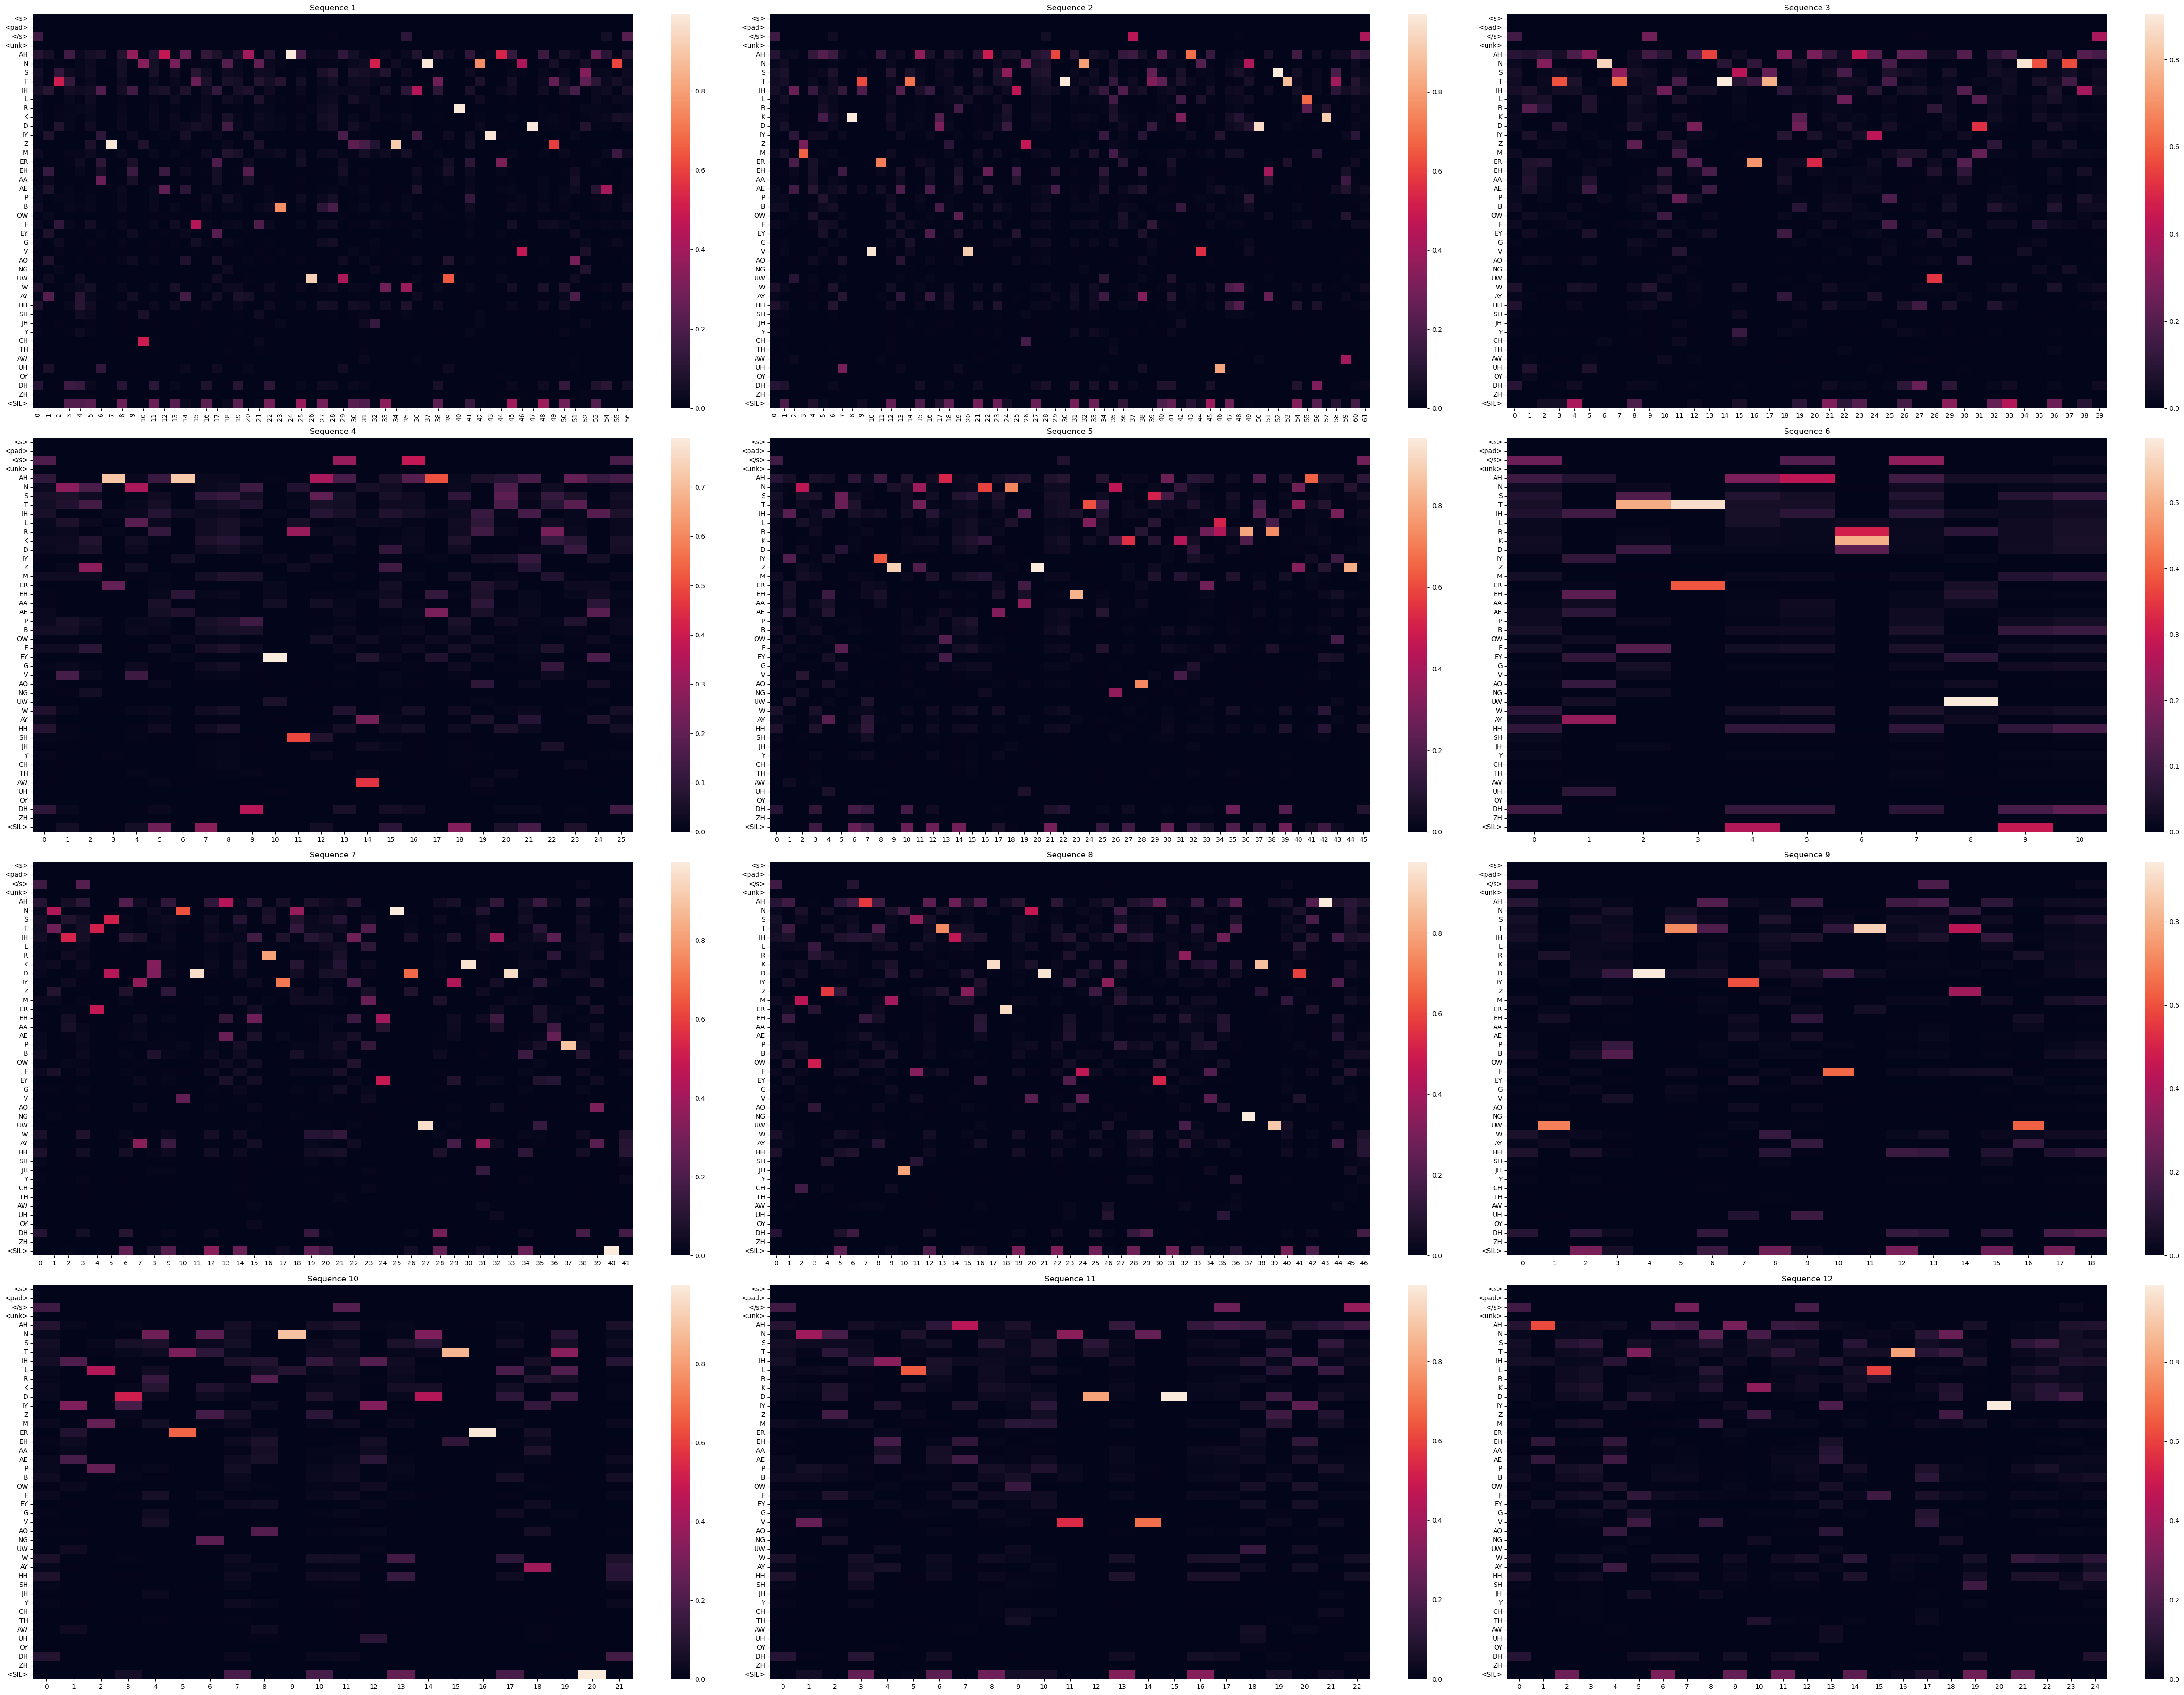

In [66]:
plot_heatmap_grid(predictograms_w2d)

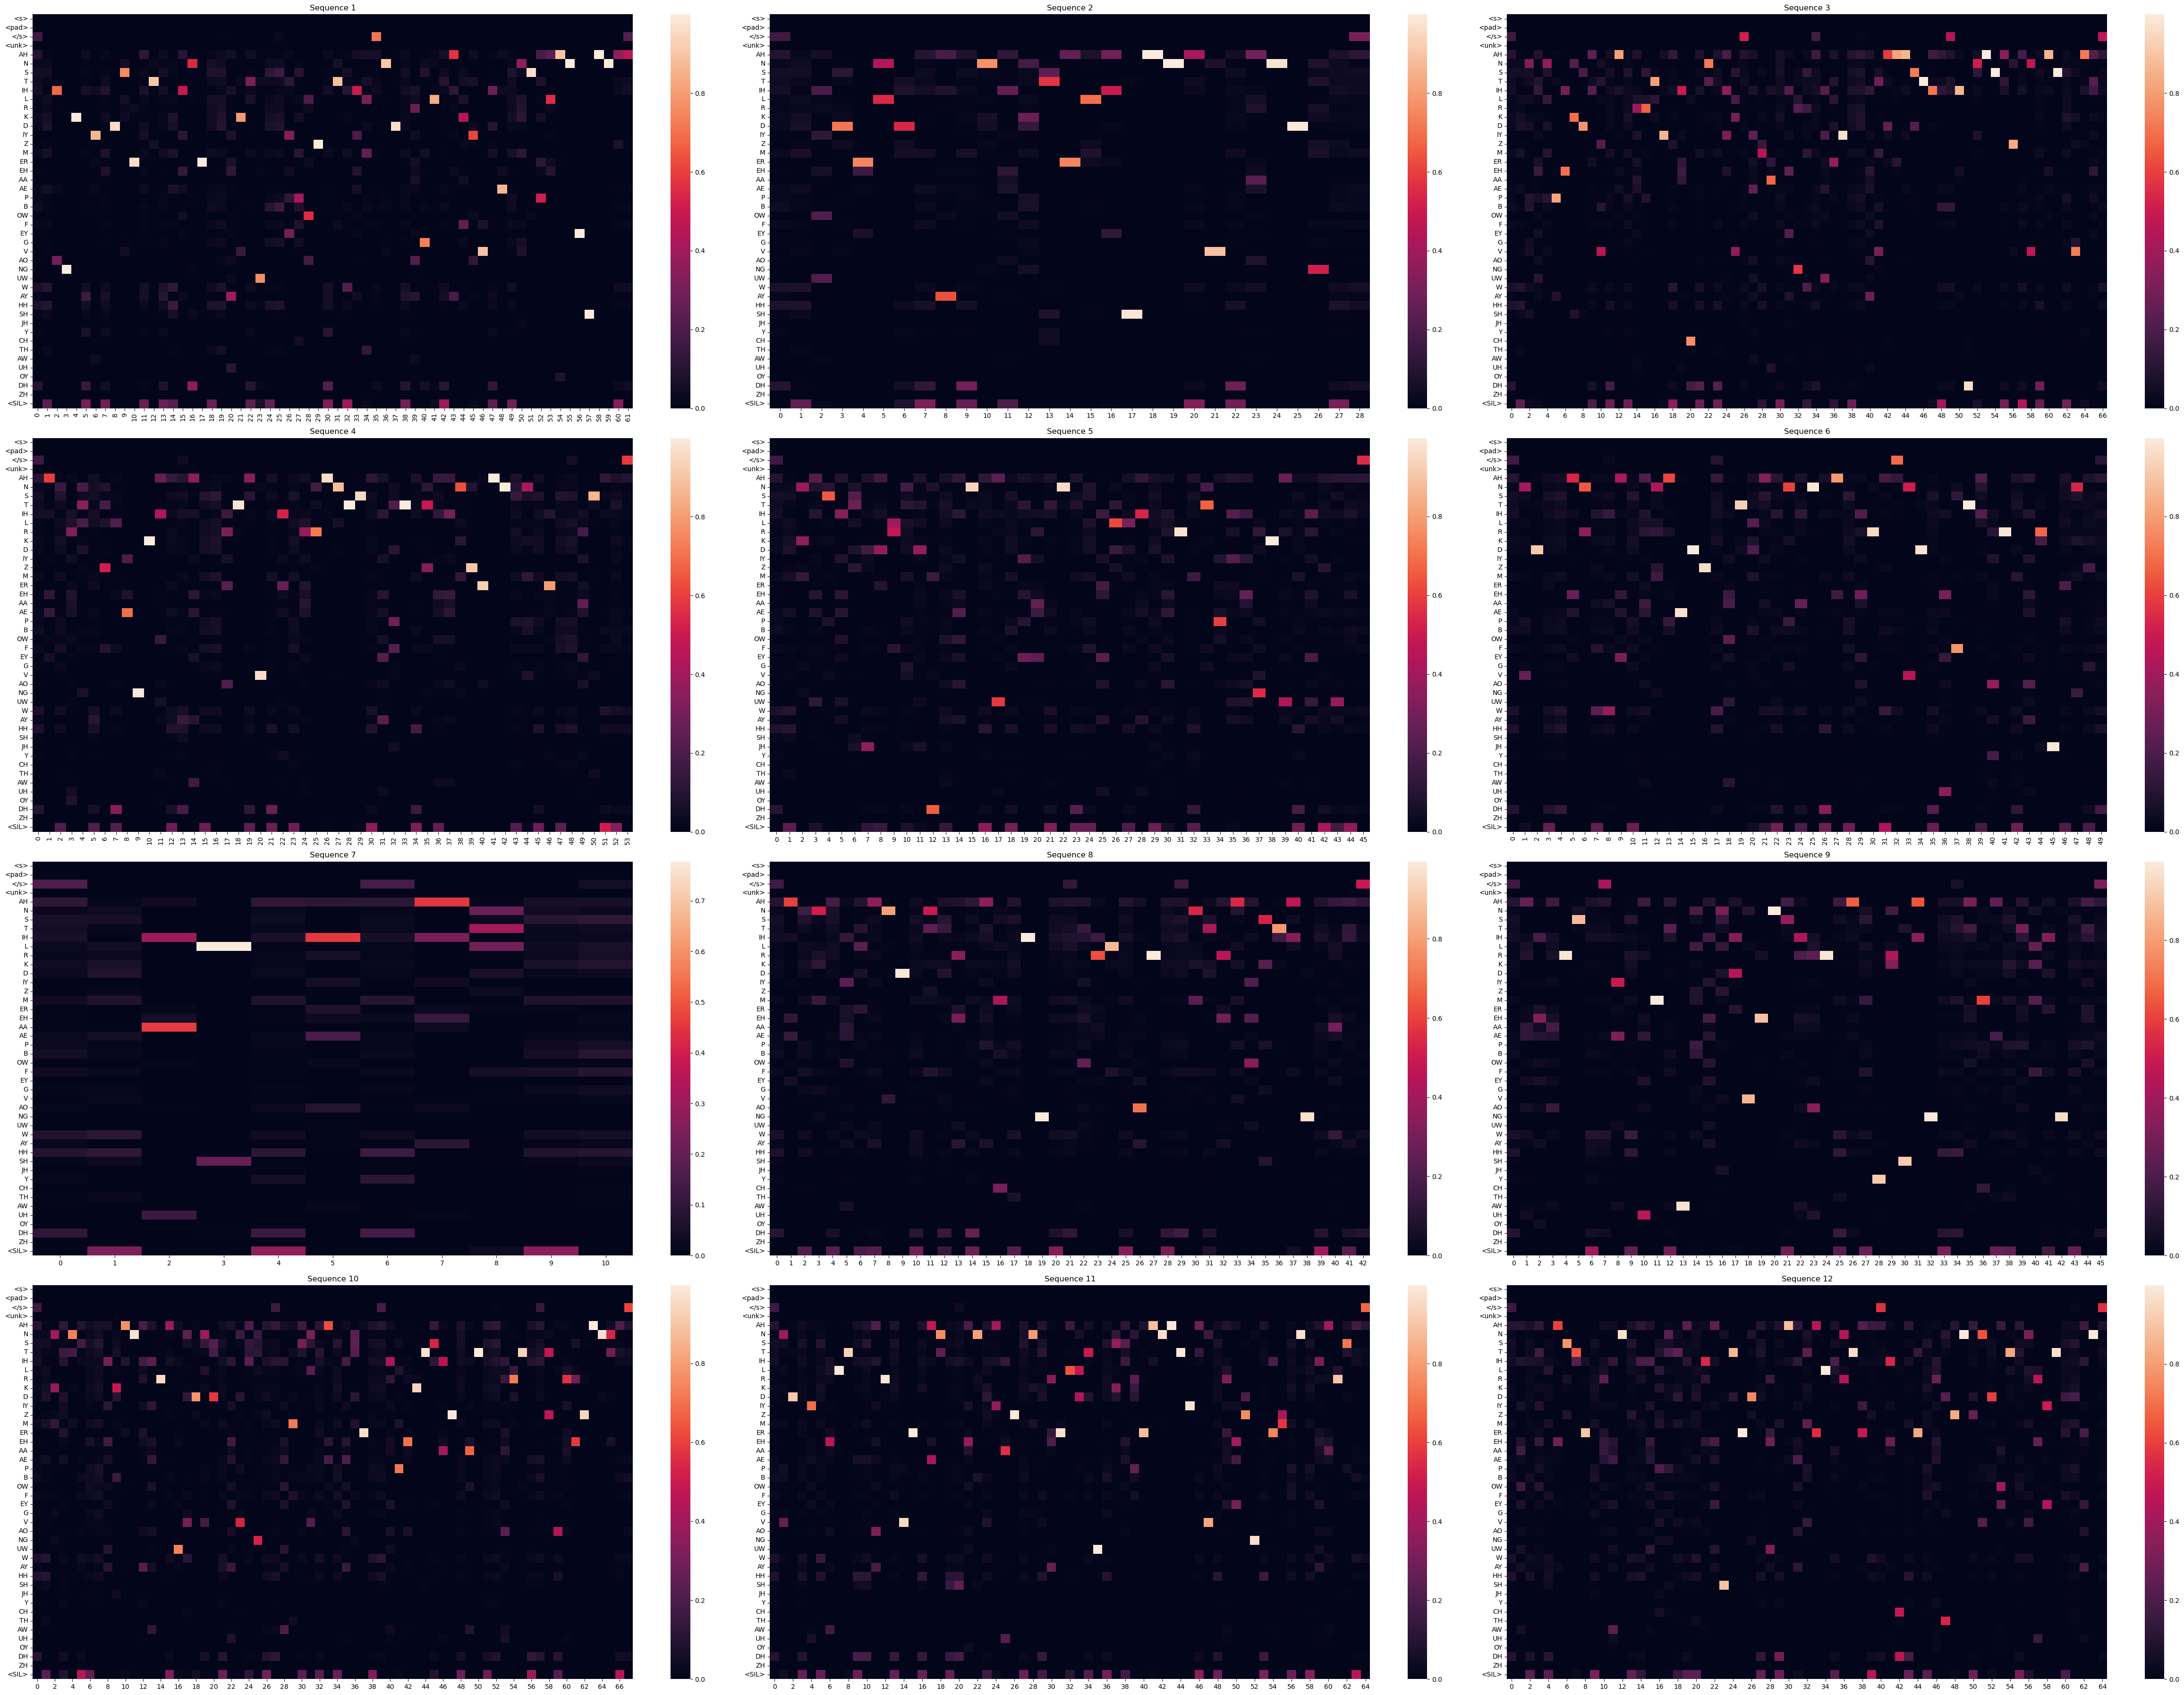

In [67]:
plot_heatmap_grid(predictograms_w2p)

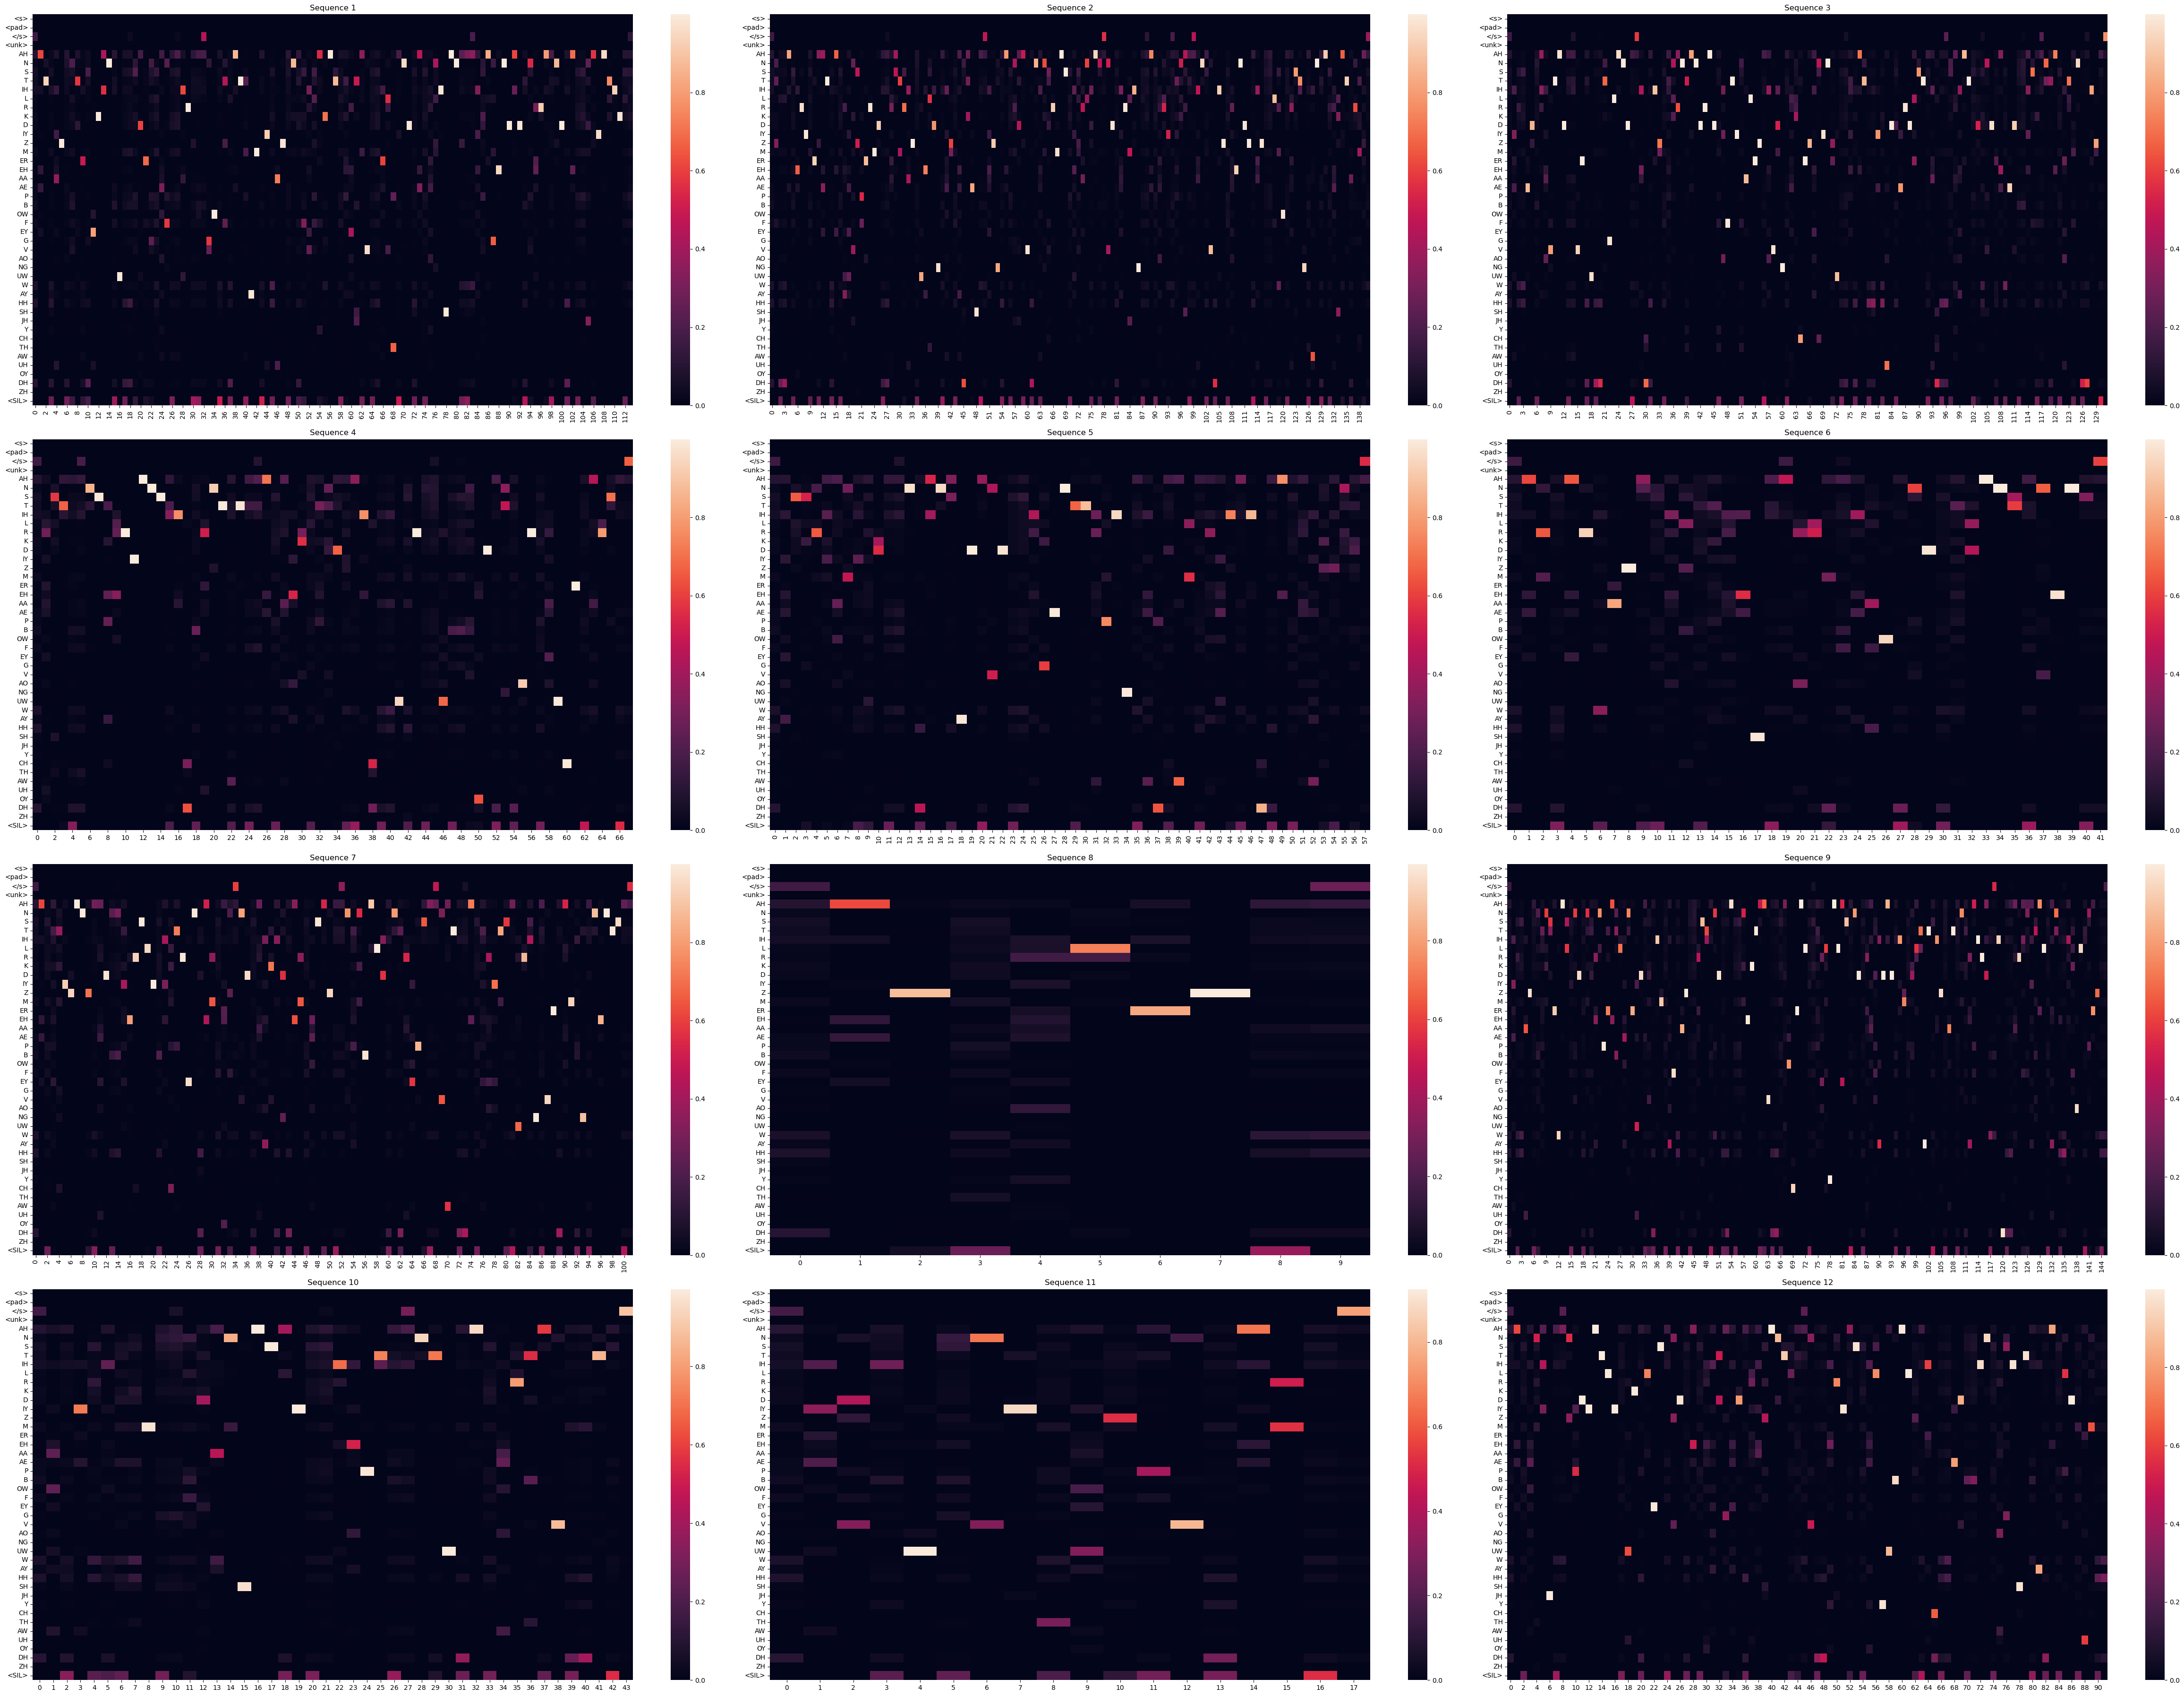

In [68]:
plot_heatmap_grid(predictograms_gt)

## Discriminability w2p and w2d predictograms

In [72]:
discriminator_dim = 384
discriminator_depth = 2
discriminator_kernel = 8
discriminator_linear_emb = False
discriminator_causal = True
discriminator_max_pool = False
discriminator_act_after_linear = False
discriminator_dropout = 0.0
discriminator_weight_norm = False
discriminator_dilation = 1
discriminator_linear_emb = False
discriminator_spectral_norm = False
discriminator_batch_size = 160
device = 'cuda'
seed = 11
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

In [73]:
class Discriminator(nn.Module):
    def __init__(self, dim, out_dim):
        super().__init__()

        inner_dim = discriminator_dim
        kernel = discriminator_kernel
        dilation = discriminator_dilation
        self.max_pool = discriminator_max_pool

        if discriminator_causal:
            padding = kernel - 1
        else:
            padding = kernel // 2

        def make_conv(in_d, out_d, k, p=0, has_dilation=True):
            conv = nn.Conv1d(
                in_d,
                out_d,
                kernel_size=k,
                padding=p,
                dilation=dilation if has_dilation else 1,
            )
            if discriminator_spectral_norm:
                conv = nn.utils.spectral_norm(conv)
            elif discriminator_weight_norm:
                conv = nn.utils.weight_norm(conv)
            return conv

        inner_net = [
            nn.Sequential(
                make_conv(inner_dim, inner_dim, kernel, padding),
                SamePad(kernel_size=kernel, causal=discriminator_causal),
                nn.Dropout(discriminator_dropout),
                nn.GELU(),
            )
            for _ in range(discriminator_depth - 1)
        ] + [
            make_conv(inner_dim, out_dim, kernel, padding, has_dilation=False),
            SamePad(kernel_size=kernel, causal=discriminator_causal),
        ]

        if discriminator_linear_emb:
            emb_net = [make_conv(dim, inner_dim, 1)]
        else:
            emb_net = [
                make_conv(dim, inner_dim, kernel, padding),
                SamePad(kernel_size=kernel, causal=discriminator_causal),
            ]

        if discriminator_act_after_linear:
            emb_net.append(nn.GELU())

        self.net = nn.Sequential(
            *emb_net,
            nn.Dropout(discriminator_dropout),
            *inner_net,
        )

    def forward(self, x, padding_mask):
        x = x.transpose(1, 2)  # BTC -> BCT
        x = self.net(x)
        x = x.transpose(1, 2)
        x_sz = x.size(1)
        if padding_mask is not None and padding_mask.any() and padding_mask.dim() > 1:
            padding_mask = padding_mask[:, : x.size(1)]
            x[padding_mask] = float("-inf") if self.max_pool else 0
            x_sz = x_sz - padding_mask.sum(dim=-1)
        x = x.squeeze(-1)
        if self.max_pool:
            x, _ = x.max(dim=-1)
        else:
            x = x.sum(dim=-1)
            x = x / x_sz
        return x

In [74]:
n_samples = len(predictograms_w2p)
targets = torch.concatenate([torch.zeros((n_samples,)), 
                             torch.ones((n_samples,))])
input_tensors = predictograms_w2p + predictograms_w2d

# Define a custom dataset class
class CustomDataset(Dataset):
    def __init__(self, inputs, targets):
        self.inputs = inputs
        self.targets = targets

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, index):
        input_tensor = self.inputs[index]
        target = self.targets[index]
        return input_tensor, target

# Create an instance of the custom dataset
dataset = CustomDataset(input_tensors, targets)

# Define a collate function to handle variable-length sequences and create padding mask
def collate_fn(batch):
    inputs, targets = zip(*batch)
    padded_inputs = pad_sequence(inputs, batch_first=True)
    mask = torch.ones((padded_inputs.size(0), padded_inputs.size(1)), dtype=torch.bool)  # Create a mask tensor of ones
    for i, seq in enumerate(inputs):
        seq_len = seq.size(0)
        mask[i, :seq_len] = False  # Set positions corresponding to the sequence to False
    return padded_inputs.to(device), torch.stack(targets).to(device), mask.to(device)

# Create a dataloader with the collate_fn argument
dataloader = DataLoader(dataset, batch_size=discriminator_batch_size, shuffle=True, collate_fn=collate_fn)

In [52]:
wandb.init(project='w2v-u-indy', name=f'disc-predictogram-w2d-w2p', entity='indy-lis')
# Define the model
classifier = Discriminator(input_tensors[0].size(-1), 1).to(device)
# Define the optimizer
optimizer = torch.optim.Adam(classifier.parameters(), lr=3e-4, betas=(0.5, 0.98), eps=1e-06, weight_decay=0.0001)
# Define the number of training epochs
max_updates = 10000
n_updates = 0
epoch = 0
# Train the model
while True:
    losses = []
    for inputs, targets, mask in dataloader:
        # Forward pass
        outputs = classifier(inputs, mask)

        # Calculate the loss
        loss = F.binary_cross_entropy_with_logits(outputs, targets)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        n_updates += 1
        losses.append(loss.item())
        wandb.log({
            "iter": n_updates,
            "train/loss": losses[-1]})
        if n_updates >= max_updates:
            break
    if n_updates >= max_updates:
        print(f"Epoch {epoch}[{n_updates}/{max_updates}] updates, Loss: {np.mean(losses)}")
        break
    epoch += 1
    # Print the loss for every epoch
    print(f"Epoch {epoch}[{n_updates}/{max_updates}] updates, Loss: {np.mean(losses)}")
wandb.finish()

wandb: Currently logged in as: dscuervog (indy-lis). Use `wandb login --relogin` to force relogin


Epoch 1[34/10000] updates, Loss: 0.6571421430391424
Epoch 2[68/10000] updates, Loss: 0.5571273232207579
Epoch 3[102/10000] updates, Loss: 0.5380319751360837
Epoch 4[136/10000] updates, Loss: 0.5304035973899505
Epoch 5[170/10000] updates, Loss: 0.5086718955460716
Epoch 6[204/10000] updates, Loss: 0.49658873326638164
Epoch 7[238/10000] updates, Loss: 0.5036692224881228
Epoch 8[272/10000] updates, Loss: 0.5023513602859834
Epoch 9[306/10000] updates, Loss: 0.5061806177391726
Epoch 10[340/10000] updates, Loss: 0.4836614692912382
Epoch 11[374/10000] updates, Loss: 0.47237690012244615
Epoch 12[408/10000] updates, Loss: 0.4823240068028955
Epoch 13[442/10000] updates, Loss: 0.4732050904456307
Epoch 14[476/10000] updates, Loss: 0.46176355638924765
Epoch 15[510/10000] updates, Loss: 0.45872393075157614
Epoch 16[544/10000] updates, Loss: 0.46040619646801667
Epoch 17[578/10000] updates, Loss: 0.4390106667928836
Epoch 18[612/10000] updates, Loss: 0.41146854179746967
Epoch 19[646/10000] updates, Loss

Epoch 149[5066/10000] updates, Loss: 0.013438665650432861
Epoch 150[5100/10000] updates, Loss: 0.014035451910732214
Epoch 151[5134/10000] updates, Loss: 0.01503714625398382
Epoch 152[5168/10000] updates, Loss: 0.016200913605965015
Epoch 153[5202/10000] updates, Loss: 0.011928340940571883
Epoch 154[5236/10000] updates, Loss: 0.016197848667856948
Epoch 155[5270/10000] updates, Loss: 0.01075964503145181
Epoch 156[5304/10000] updates, Loss: 0.0121452425399398
Epoch 157[5338/10000] updates, Loss: 0.012877259677382239
Epoch 158[5372/10000] updates, Loss: 0.011500239490701728
Epoch 159[5406/10000] updates, Loss: 0.017426891457837296
Epoch 160[5440/10000] updates, Loss: 0.04019107247072765
Epoch 161[5474/10000] updates, Loss: 0.015588344898252912
Epoch 162[5508/10000] updates, Loss: 0.009162665858371732
Epoch 163[5542/10000] updates, Loss: 0.008527236347778371
Epoch 164[5576/10000] updates, Loss: 0.009767365593956235
Epoch 165[5610/10000] updates, Loss: 0.023961864410974906
Epoch 166[5644/1000

Epoch 291[9894/10000] updates, Loss: 0.011089865693446988
Epoch 292[9928/10000] updates, Loss: 0.0038463965551354773
Epoch 293[9962/10000] updates, Loss: 0.00416709143695805
Epoch 294[9996/10000] updates, Loss: 0.0046921600587666035
Epoch 294[10000/10000] updates, Loss: 0.004774647473823279


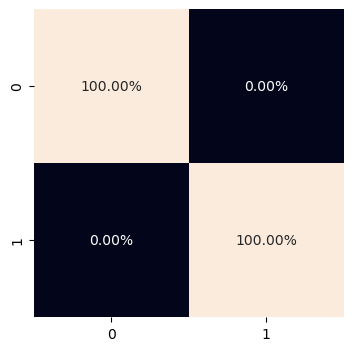

F1-score: 1.0


In [53]:
preds = []
targets = []
classifier.eval()

with torch.no_grad():
    for inputs, batch_targets, mask in dataloader:
        # Forward pass
        batch_outputs = classifier(inputs, mask)
        preds += (F.sigmoid(batch_outputs).round().tolist())
        targets += (batch_targets.tolist())
conf_matrix = confusion_matrix(targets, preds)
plt.figure(figsize=(4, 4))
sns.heatmap(conf_matrix / np.sum(conf_matrix, 1, keepdims=True), annot=True, fmt=".2%", cbar=False)
plt.show()
print(f"F1-score: {f1_score(targets, preds, average='macro')}")

## Discriminability w2p and ground truth predictograms

In [54]:
n_samples = len(predictograms_w2p)
targets = torch.concatenate([torch.zeros((n_samples,)), 
                             torch.ones((n_samples,))])
input_tensors = predictograms_w2p + predictograms_gt

# Define a custom dataset class
class CustomDataset(Dataset):
    def __init__(self, inputs, targets):
        self.inputs = inputs
        self.targets = targets

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, index):
        input_tensor = self.inputs[index]
        target = self.targets[index]
        return input_tensor, target

# Create an instance of the custom dataset
dataset = CustomDataset(input_tensors, targets)

# Define a collate function to handle variable-length sequences and create padding mask
def collate_fn(batch):
    inputs, targets = zip(*batch)
    padded_inputs = pad_sequence(inputs, batch_first=True)
    mask = torch.ones((padded_inputs.size(0), padded_inputs.size(1)), dtype=torch.bool)  # Create a mask tensor of ones
    for i, seq in enumerate(inputs):
        seq_len = seq.size(0)
        mask[i, :seq_len] = False  # Set positions corresponding to the sequence to False
    return padded_inputs.to(device), torch.stack(targets).to(device), mask.to(device)

# Create a dataloader with the collate_fn argument
dataloader = DataLoader(dataset, batch_size=discriminator_batch_size, shuffle=True, collate_fn=collate_fn)

In [55]:
wandb.init(project='w2v-u-indy', name=f'disc-predictogram-w2p-gt', entity='indy-lis')
# Define the model
classifier = Discriminator(input_tensors[0].size(-1), 1).to(device)
# Define the optimizer
optimizer = torch.optim.Adam(classifier.parameters(), lr=3e-4, betas=(0.5, 0.98), eps=1e-06, weight_decay=0.0001)
# Define the number of training epochs
max_updates = 10000
n_updates = 0
epoch = 0
# Train the model
while True:
    losses = []
    for inputs, targets, mask in dataloader:
        # Forward pass
        outputs = classifier(inputs, mask)

        # Calculate the loss
        loss = F.binary_cross_entropy_with_logits(outputs, targets)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        n_updates += 1
        losses.append(loss.item())
        wandb.log({
            "iter": n_updates,
            "train/loss": losses[-1]})
        if n_updates >= max_updates:
            break
    if n_updates >= max_updates:
        print(f"Epoch {epoch}[{n_updates}/{max_updates}] updates, Loss: {np.mean(losses)}")
        break
    epoch += 1
    # Print the loss for every epoch
    print(f"Epoch {epoch}[{n_updates}/{max_updates}] updates, Loss: {np.mean(losses)}")
wandb.finish()

iter,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train/loss,▇▇█▅▃▃▂▃▂▂▂▂▁▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
iter,10000
train/loss,0.00248


Epoch 1[34/10000] updates, Loss: 0.6842168920180377
Epoch 2[68/10000] updates, Loss: 0.6372221918667064
Epoch 3[102/10000] updates, Loss: 0.6088973459075478
Epoch 4[136/10000] updates, Loss: 0.592904648360084
Epoch 5[170/10000] updates, Loss: 0.597415442852413
Epoch 6[204/10000] updates, Loss: 0.5930825454347274
Epoch 7[238/10000] updates, Loss: 0.6063883409780615
Epoch 8[272/10000] updates, Loss: 0.5962099345291362
Epoch 9[306/10000] updates, Loss: 0.5878537411198896
Epoch 10[340/10000] updates, Loss: 0.5909183042890885
Epoch 11[374/10000] updates, Loss: 0.5912177492590511
Epoch 12[408/10000] updates, Loss: 0.5913607863818898
Epoch 13[442/10000] updates, Loss: 0.5851734578609467
Epoch 14[476/10000] updates, Loss: 0.5844404118902543
Epoch 15[510/10000] updates, Loss: 0.5763199679991778
Epoch 16[544/10000] updates, Loss: 0.5867550679866005
Epoch 17[578/10000] updates, Loss: 0.5651406102320727
Epoch 18[612/10000] updates, Loss: 0.5547344062258216
Epoch 19[646/10000] updates, Loss: 0.5505

Epoch 149[5066/10000] updates, Loss: 0.11939025264890755
Epoch 150[5100/10000] updates, Loss: 0.1146148185190909
Epoch 151[5134/10000] updates, Loss: 0.1138401914607076
Epoch 152[5168/10000] updates, Loss: 0.11123512389467043
Epoch 153[5202/10000] updates, Loss: 0.11445936538717326
Epoch 154[5236/10000] updates, Loss: 0.10851294381598778
Epoch 155[5270/10000] updates, Loss: 0.1099578748073648
Epoch 156[5304/10000] updates, Loss: 0.10702746514888371
Epoch 157[5338/10000] updates, Loss: 0.10993812025031623
Epoch 158[5372/10000] updates, Loss: 0.09614828755729832
Epoch 159[5406/10000] updates, Loss: 0.10216523411081117
Epoch 160[5440/10000] updates, Loss: 0.10672937234887607
Epoch 161[5474/10000] updates, Loss: 0.09717980649378767
Epoch 162[5508/10000] updates, Loss: 0.09352788496214677
Epoch 163[5542/10000] updates, Loss: 0.09531016886124716
Epoch 164[5576/10000] updates, Loss: 0.09629273732357166
Epoch 165[5610/10000] updates, Loss: 0.09421412767294575
Epoch 166[5644/10000] updates, Los

Epoch 293[9962/10000] updates, Loss: 0.04696158267667189
Epoch 294[9996/10000] updates, Loss: 0.012755392694189408
Epoch 294[10000/10000] updates, Loss: 0.011172738508321345


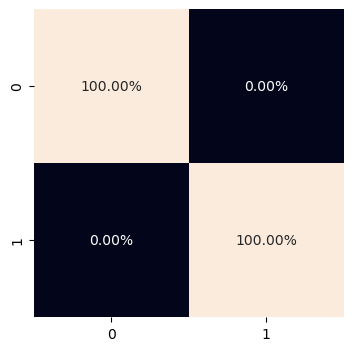

F1-score: 1.0


In [56]:
preds = []
targets = []
classifier.eval()

with torch.no_grad():
    for inputs, batch_targets, mask in dataloader:
        # Forward pass
        batch_outputs = classifier(inputs, mask)
        preds += (F.sigmoid(batch_outputs).round().tolist())
        targets += (batch_targets.tolist())
conf_matrix = confusion_matrix(targets, preds)
plt.figure(figsize=(4, 4))
sns.heatmap(conf_matrix / np.sum(conf_matrix, 1, keepdims=True), annot=True, fmt=".2%", cbar=False)
plt.show()
print(f"F1-score: {f1_score(targets, preds, average='macro')}")

## Discriminability w2d and ground truth predictograms

In [75]:
n_samples = len(predictograms_w2p)
targets = torch.concatenate([torch.zeros((n_samples,)), 
                             torch.ones((n_samples,))])
input_tensors = predictograms_w2d + predictograms_gt

# Define a custom dataset class
class CustomDataset(Dataset):
    def __init__(self, inputs, targets):
        self.inputs = inputs
        self.targets = targets

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, index):
        input_tensor = self.inputs[index]
        target = self.targets[index]
        return input_tensor, target

# Create an instance of the custom dataset
dataset = CustomDataset(input_tensors, targets)

# Define a collate function to handle variable-length sequences and create padding mask
def collate_fn(batch):
    inputs, targets = zip(*batch)
    padded_inputs = pad_sequence(inputs, batch_first=True)
    mask = torch.ones((padded_inputs.size(0), padded_inputs.size(1)), dtype=torch.bool)  # Create a mask tensor of ones
    for i, seq in enumerate(inputs):
        seq_len = seq.size(0)
        mask[i, :seq_len] = False  # Set positions corresponding to the sequence to False
    return padded_inputs.to(device), torch.stack(targets).to(device), mask.to(device)

# Create a dataloader with the collate_fn argument
dataloader = DataLoader(dataset, batch_size=discriminator_batch_size, shuffle=True, collate_fn=collate_fn)

In [76]:
wandb.init(project='w2v-u-indy', name=f'disc-predictogram-w2d-gt', entity='indy-lis')
# Define the model
classifier = Discriminator(input_tensors[0].size(-1), 1).to(device)
# Define the optimizer
optimizer = torch.optim.Adam(classifier.parameters(), lr=3e-4, betas=(0.5, 0.98), eps=1e-06, weight_decay=0.0001)
# Define the number of training epochs
max_updates = 10000
n_updates = 0
epoch = 0
# Train the model
while True:
    losses = []
    for inputs, targets, mask in dataloader:
        # Forward pass
        outputs = classifier(inputs, mask)

        # Calculate the loss
        loss = F.binary_cross_entropy_with_logits(outputs, targets)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        n_updates += 1
        losses.append(loss.item())
        wandb.log({
            "iter": n_updates,
            "train/loss": losses[-1]})
        if n_updates >= max_updates:
            break
    if n_updates >= max_updates:
        print(f"Epoch {epoch}[{n_updates}/{max_updates}] updates, Loss: {np.mean(losses)}")
        break
    epoch += 1
    # Print the loss for every epoch
    print(f"Epoch {epoch}[{n_updates}/{max_updates}] updates, Loss: {np.mean(losses)}")
wandb.finish()

wandb: Currently logged in as: dscuervog (indy-lis). Use `wandb login --relogin` to force relogin


Epoch 1[34/10000] updates, Loss: 0.6440273996661691
Epoch 2[68/10000] updates, Loss: 0.4999225078260197
Epoch 3[102/10000] updates, Loss: 0.4631434906931484
Epoch 4[136/10000] updates, Loss: 0.45571931232424345
Epoch 5[170/10000] updates, Loss: 0.4583283163168851
Epoch 6[204/10000] updates, Loss: 0.43098685057724223
Epoch 7[238/10000] updates, Loss: 0.4413760172970155
Epoch 8[272/10000] updates, Loss: 0.40691710877067905
Epoch 9[306/10000] updates, Loss: 0.39184360469088836
Epoch 10[340/10000] updates, Loss: 0.3850952974137138
Epoch 11[374/10000] updates, Loss: 0.412260766415035
Epoch 12[408/10000] updates, Loss: 0.37173814501832514
Epoch 13[442/10000] updates, Loss: 0.32629386795794263
Epoch 14[476/10000] updates, Loss: 0.3191403891233837
Epoch 15[510/10000] updates, Loss: 0.30103571537662954
Epoch 16[544/10000] updates, Loss: 0.2723415607915205
Epoch 17[578/10000] updates, Loss: 0.2614639977760175
Epoch 18[612/10000] updates, Loss: 0.22915494102327263
Epoch 19[646/10000] updates, Los

Epoch 147[4998/10000] updates, Loss: 0.006547067334930248
Epoch 148[5032/10000] updates, Loss: 0.013593278017223757
Epoch 149[5066/10000] updates, Loss: 0.004876673714641263
Epoch 150[5100/10000] updates, Loss: 0.005541407242965172
Epoch 151[5134/10000] updates, Loss: 0.017171987613170025
Epoch 152[5168/10000] updates, Loss: 0.0064210105107817715
Epoch 153[5202/10000] updates, Loss: 0.004615773029125675
Epoch 154[5236/10000] updates, Loss: 0.00516639869163234
Epoch 155[5270/10000] updates, Loss: 0.00591210147831589
Epoch 156[5304/10000] updates, Loss: 0.005920978269868475
Epoch 157[5338/10000] updates, Loss: 0.0061870794345261805
Epoch 158[5372/10000] updates, Loss: 0.0060223537216456055
Epoch 159[5406/10000] updates, Loss: 0.0059668352118665904
Epoch 160[5440/10000] updates, Loss: 0.005342613967299899
Epoch 161[5474/10000] updates, Loss: 0.005357535665525692
Epoch 162[5508/10000] updates, Loss: 0.008441134635551647
Epoch 163[5542/10000] updates, Loss: 0.0046127937076722875
Epoch 164[5

Epoch 288[9792/10000] updates, Loss: 0.003067765298925117
Epoch 289[9826/10000] updates, Loss: 0.0029917427591984133
Epoch 290[9860/10000] updates, Loss: 0.004519430348677013
Epoch 291[9894/10000] updates, Loss: 0.003426946456195711
Epoch 292[9928/10000] updates, Loss: 0.0037900000243098475
Epoch 293[9962/10000] updates, Loss: 0.002802748726133038
Epoch 294[9996/10000] updates, Loss: 0.0050648919936707795
Epoch 294[10000/10000] updates, Loss: 0.00410578737501055


iter,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train/loss,▇█▅▃▃▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
iter,10000
train/loss,0.00313


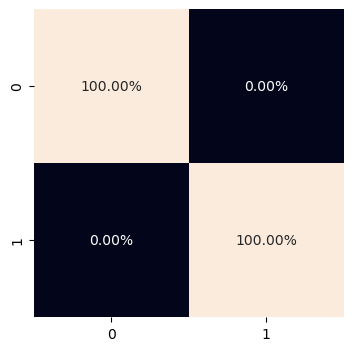

F1-score: 1.0


In [77]:
preds = []
targets = []
classifier.eval()

with torch.no_grad():
    for inputs, batch_targets, mask in dataloader:
        # Forward pass
        batch_outputs = classifier(inputs, mask)
        preds += (F.sigmoid(batch_outputs).round().tolist())
        targets += (batch_targets.tolist())
conf_matrix = confusion_matrix(targets, preds)
plt.figure(figsize=(4, 4))
sns.heatmap(conf_matrix / np.sum(conf_matrix, 1, keepdims=True), annot=True, fmt=".2%", cbar=False)
plt.show()
print(f"F1-score: {f1_score(targets, preds, average='macro')}")

In [78]:
torch.save(classifier.state_dict(), 'disc-predictogram-w2d-gt.pt')

# Comparing predictograms' utterances' logprobs on different posteriograms

In [25]:
target_dict = task._target_dictionary
lm_ckpt = "/home/santiago.cuervo/ssl/nanoGPT/out-librispeech-phn/en/ckpt.pt"
# Load GPT model and encoder
checkpoint = torch.load(lm_ckpt) # , map_location=p.device)
if os.path.isfile(os.path.join(os.path.dirname(lm_ckpt), "dict.txt")):
    print("LM dict provided. Re-ordering LM embeddings to match with data codes")
    with open(os.path.join(os.path.dirname(lm_ckpt), "dict.txt"), "r") as f:
        lm_vocab = [x.split()[0] for x in f]
    assert set(lm_vocab) == set(target_dict.symbols), "The task and LM vocabularies don't match"
    # Sort list2 using list1 as a key
    sorted_list2 = sorted(lm_vocab, key=lambda x: target_dict.symbols.index(x))
    # Get the indices that would sort list2 to be the same as list1
    indices = [lm_vocab.index(x) for x in sorted_list2]
gptconf = GPTConfig(**checkpoint['model_args'])
state_dict = checkpoint['model']
# Re-arrange embeddings and output units so that the task codes will match the embeddings codes
state_dict["transformer.wte.weight"] = state_dict["transformer.wte.weight"][indices]
state_dict["lm_head.weight.weight"] = state_dict["lm_head.weight"][indices]
model = GPT(gptconf)
model.load_state_dict(state_dict)
model.cuda()

LM dict provided. Re-ordering LM embeddings to match with data codes
LM number of parameters: 5.33M


GPT(
  (transformer): ModuleDict(
    (wte): Embedding(44, 384)
    (wpe): Embedding(256, 384)
    (drop): Dropout(p=0.2, inplace=False)
    (h): ModuleList(
      (0-2): 3 x Block(
        (ln_1): LayerNorm()
        (attn): CausalSelfAttention(
          (c_attn): Linear(in_features=384, out_features=1152, bias=False)
          (c_proj): Linear(in_features=384, out_features=384, bias=False)
          (attn_dropout): Dropout(p=0.2, inplace=False)
          (resid_dropout): Dropout(p=0.2, inplace=False)
        )
        (ln_2): LayerNorm()
        (mlp): MLP(
          (c_fc): Linear(in_features=384, out_features=1536, bias=False)
          (c_proj): Linear(in_features=1536, out_features=384, bias=False)
          (dropout): Dropout(p=0.2, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm()
  )
  (lm_head): Linear(in_features=384, out_features=44, bias=False)
)

In [26]:
def get_batch(itr, predictor):
    net_in = next(itr)['net_input']
    x, mask = net_in['features'], net_in['padding_mask']
    x, mask = x.to(device), mask.to(device)
    y = None
    if 'random_label' in net_in:
        y = net_in['random_label']
        y = y.to(device)
    gen_result = predictor(x, mask, y, dense_x_only=True)
    x = gen_result["logits"]
    mask = gen_result["padding_mask"]
    x = x[:, :-1]
    mask = mask[:, :-1]
    return x, y, mask

In [29]:
logp_w2d = []
logp_w2p = []
logp_gt = []
# training loop
train_itr_w2d = get_batch_iterator('train', epoch=1)
train_itr_w2p = get_batch_iterator('train', epoch=1)
X_w2d, Y_w2d, mask_w2d = get_batch(train_itr_w2d, wav2dyn)
X_w2p, Y_w2p, mask_w2p = get_batch(train_itr_w2p, wav2phn)
while True:
    with torch.no_grad():
        mask_gt = (Y_w2d == wav2dyn.pad)[:, :wav2dyn.block_size]
        X_gt = F.one_hot(Y_w2d, num_classes=len(task.target_dictionary.symbols))[:, :wav2dyn.block_size].float()
        _, _, probs_w2d, _ = model(X_w2d, return_posteriograms=True)
        _, _, probs_w2p, _ = model(X_w2p, return_posteriograms=True)
        _, _, probs_gt, _ = model(X_gt, return_posteriograms=True)
        unpadded_X_w2d = get_unpadded_sequences(X_w2d, mask_w2d)
        unpadded_probs_w2d = get_unpadded_sequences(probs_w2d, mask_w2d)
        logp_w2d_i = []
        for x, p in zip(unpadded_X_w2d, unpadded_probs_w2d):
            next_tokens = x.argmax(-1)[1:]
            logp_w2d_i.append(torch.log(torch.index_select(p[:-1], dim=-1, index=next_tokens)).mean().item())
        unpadded_X_w2p = get_unpadded_sequences(X_w2p, mask_w2p)
        unpadded_probs_w2p = get_unpadded_sequences(probs_w2p, mask_w2p)
        logp_w2p_i = []
        for x, p in zip(unpadded_X_w2p, unpadded_probs_w2p):
            next_tokens = x.argmax(-1)[1:]
            logp_w2p_i.append(torch.log(torch.index_select(p[:-1], dim=-1, index=next_tokens)).mean().item())
        unpadded_X_gt = get_unpadded_sequences(X_gt, mask_gt)
        unpadded_probs_gt = get_unpadded_sequences(probs_gt, mask_gt)
        logp_gt_i = []
        for x, p in zip(unpadded_X_gt, unpadded_probs_gt):
            next_tokens = x.argmax(-1)[1:]
            logp_gt_i.append(torch.log(torch.index_select(p[:-1], dim=-1, index=next_tokens)).mean().item())
        logp_w2d += logp_w2d_i
        logp_w2p += logp_w2p_i
        logp_gt += logp_gt_i
    try:
        X_w2d, Y_w2d, mask_w2d = get_batch(train_itr_w2d, wav2dyn)
        X_w2p, Y_w2p, mask_w2p = get_batch(train_itr_w2p, wav2phn)
    except StopIteration:
        break

In [30]:
print("Log prob(seq) w2d: ", np.mean(logp_w2d))
print("Log prob(seq) w2p: ", np.mean(logp_w2p))
print("Log prob(seq) gt: ", np.mean(logp_gt))

Log prob(seq) w2d:  -6.20627710756954
Log prob(seq) w2p:  -6.105452143031059
Log prob(seq) gt:  -6.565644546423568


In [31]:
logp_w2d = []
logp_w2p = []
logp_gt = []
# training loop
train_itr_w2d = get_batch_iterator('train', epoch=1)
train_itr_w2p = get_batch_iterator('train', epoch=1)
X_w2d, Y_w2d, mask_w2d = get_batch(train_itr_w2d, wav2dyn)
X_w2p, Y_w2p, mask_w2p = get_batch(train_itr_w2p, wav2phn)
while True:
    with torch.no_grad():
        mask_gt = (Y_w2d == wav2dyn.pad)[:, :wav2dyn.block_size]
        X_gt = F.one_hot(Y_w2d, num_classes=len(task.target_dictionary.symbols))[:, :wav2dyn.block_size].float()
        _, _, probs_w2d, _ = model(F.one_hot(X_w2d.argmax(-1), num_classes=len(task.target_dictionary.symbols)).float(), return_posteriograms=True)
        _, _, probs_w2p, _ = model(F.one_hot(X_w2p.argmax(-1), num_classes=len(task.target_dictionary.symbols)).float(), return_posteriograms=True)
        _, _, probs_gt, _ = model(X_gt, return_posteriograms=True)
        
        unpadded_X_w2d = get_unpadded_sequences(X_w2d, mask_w2d)
        unpadded_probs_w2d = get_unpadded_sequences(probs_w2d, mask_w2d)
        logp_w2d_i = []
        for x, p in zip(unpadded_X_w2d, unpadded_probs_w2d):
            next_tokens = x.argmax(-1)[1:]
            logp_w2d_i.append(torch.log(torch.index_select(p[:-1], dim=-1, index=next_tokens)).mean().item())
        
        unpadded_X_w2p = get_unpadded_sequences(X_w2p, mask_w2p)
        unpadded_probs_w2p = get_unpadded_sequences(probs_w2p, mask_w2p)
        logp_w2p_i = []
        for x, p in zip(unpadded_X_w2p, unpadded_probs_w2p):
            next_tokens = x.argmax(-1)[1:]
            logp_w2p_i.append(torch.log(torch.index_select(p[:-1], dim=-1, index=next_tokens)).mean().item())
        
        unpadded_X_gt = get_unpadded_sequences(X_gt, mask_gt)
        unpadded_probs_gt = get_unpadded_sequences(probs_gt, mask_gt)
        logp_gt_i = []
        for x, p in zip(unpadded_X_gt, unpadded_probs_gt):
            next_tokens = x.argmax(-1)[1:]
            logp_gt_i.append(torch.log(torch.index_select(p[:-1], dim=-1, index=next_tokens)).mean().item())
        
        logp_w2d += logp_w2d_i
        logp_w2p += logp_w2p_i
        logp_gt += logp_gt_i
    try:
        X_w2d, Y_w2d, mask_w2d = get_batch(train_itr_w2d, wav2dyn)
        X_w2p, Y_w2p, mask_w2p = get_batch(train_itr_w2p, wav2phn)
    except StopIteration:
        break

In [32]:
print("Log prob(seq) w2d: ", np.mean(logp_w2d))
print("Log prob(seq) w2p: ", np.mean(logp_w2p))
print("Log prob(seq) gt: ", np.mean(logp_gt))

Log prob(seq) w2d:  -6.542321330442071
Log prob(seq) w2p:  -6.167343909701629
Log prob(seq) gt:  -6.566843207430451


In [33]:
for y, m in zip(Y_w2d, mask_gt):
    y_len = len(m) - m.sum()
    print(task.target_dictionary.string(y[:y_len]))

<SIL> AH L IH T AH L D R AY V DH OW Z W IH DH IH N DH AH SH AA P <SIL> HH AE D B IH N T UW M AH CH <SIL> IH N T R AH S T AH D IH N <SIL> DH EH R OW N P R OW S IY D IH NG Z <SIL> T UW B IY K AA N SH AH S AH V AH D AO G K AA R T <SIL> W IH CH <SIL> K EY M T EH R IH NG <SIL> TH R UW DH AH D AA R K AH N IH NG SH AE D OW Z AE T S AH CH AH <SIL> P EY S DH AE T S T AA R T AH L D P AH D EH S T R IY AH N Z M AY T B IY IH K S K Y UW Z D F AO R TH IH NG K IH NG DH AE T IH T W AA Z AH K EY S AH V AH <SIL> HH AO R S R AH N IH NG <SIL> AH W EY W IH DH IH T S D R AY V ER <SIL>
<SIL> W AH T IH F DH AH TH IH NG Z S OW K AA N F AH D AH N T L IY IH K S P EH K T AH D F R AH M DH AH V IH L AH JH SH UH D N AA T K AH M <SIL>
<SIL> AY HH OW P <SIL> IH T W IH L B IY <SIL> AH N D ER S T UH D <SIL> B AY R IY D ER Z AH V <SIL> DH IY Z P EY JH AH Z DH AE T IH N EH N IY R EH F ER AH N S IH Z AY M EY M EY K T UW D AA G M AE T IH K TH IY AA L AH JH IY AY <SIL> AE M P AE S IH NG N OW R AH F L EH K SH AH N AH P AA N DH

<SIL> HH IY AE D AH D W IH DH <SIL> AH HH AE F SH AY <SIL> HH AE F HH Y UW M ER AH S G L AE N S W AY P IH NG <SIL> HH IH Z F AO R HH EH D F R AE NG K L IY <SIL> AY D R AE DH ER F EY S AH <SIL> G R IH Z L IY DH AE N <SIL> D UW DH AE T AH G EH N <SIL>
<SIL> P EH G <SIL> S T EH R D AE T HH ER <SIL>
<SIL> SH IY D IH S AY D IH D DH AE T DH AH F AO R M ER <SIL> K AO R S <SIL> W AA Z AA N DH AH <SIL> HH OW L L EH S <SIL> OW P AH N T UW AH B JH EH K SH AH N <SIL>
<SIL> Y UW L P OW S T DH AE T <SIL>
<SIL> IH Z IH T T R UW K AH N T IH N Y UW D DH AH M EH S AH N JH ER DH AE T K AW N T P IY EH R D IY B AW CH AH JH HH AE TH IH M P R IH Z AH N D <SIL> HH IH Z <SIL> F AA DH ER F AO R F EY L Y ER T UW <SIL> P EY AH T AE K S <SIL> AH N D DH AE T DH AH F AE M AH L IY AA R N AW IH N <SIL> S AO R D IH S T R EH S <SIL>
<SIL> AE Z Y EH T AY AE M N AA T M AE D <SIL> B AH T S UW N <SIL> SH AE L <SIL> B IY <SIL>
<SIL> W IY SH UH D N AA T S AH P OW Z <SIL> DH AE T AW ER S OW L Z B IH G AE N AE T B ER TH F AO R 

<SIL> S AH M ER <SIL> B AY IY D IH TH W AO R T AH N N AY N T IY N S EH V AH N T IY N <SIL> AH G ER L K EY M AW T AH V L AO Y ER R OY AH L Z <SIL> HH AW S AE T <SIL> DH AH EH N D <SIL> AH V DH AH W AH N S T R IY T AH V <SIL> N AO R TH <SIL> D AO R M ER AH N D <SIL> S T UH D AA N DH AH D AO R S T EH P <SIL>
<SIL> HH IY S P EH N T DH AH N AY T <SIL> AE T DH AH <SIL> P AH L IY S S T EY SH AH N AO L N AY T <SIL> HH IY W AA Z AH W EH R <SIL> AH V AH L OW TH IH NG F AO R <SIL> F IH SH AH N D W AA Z TH IH NG K IH NG AH B AW T DH AH <SIL> TH R IY R UW B AH L Z AH N D DH AH K W AO R T ER AH V <SIL> AH P AW N D AH V T IY <SIL>
<SIL> DH EH R Z AH D AE SH AH V HH EY L AE T DH AH W IH N D OW <SIL> TH IH K <SIL> W IH DH D R AY V IH NG S N OW IH Z DH AH EH R B AH T AY <SIL> S IH T HH IY R IH N IY Z AH N D K AH M F ER T IH N DH AH <SIL> D EH P TH S AH V M AY <SIL> IY Z IY CH EH R <SIL>
<SIL> IH N JH EH N ER AH L HH AW EH V ER <SIL> DH AH HH AA R T F ER D W IH T S F AO T F AO R <SIL> DH AH <SIL> IH S T 

<SIL> S P EH SH AH L D IH T EY L F R AH M DH AH <SIL> AO R D N AH N S D IH P AA R T M AH N T S ER <SIL> S EH Z AY <SIL>
<SIL> HH IY T OW L D M IY AH B AW T <SIL> DH IH S <SIL> IH N V EH N SH AH N HH IY Z G AO N IH N T UW T UW <SIL>
<SIL> S OW D OW N T <SIL> T R AY T UW D IH S IY V M IY IH T <SIL> W OW N T G OW W EH L W IH DH Y UW <SIL>
<SIL> B AH T DH AH R IH Z AH L T W AA Z DH AH Y UW ZH AH W AH L IH K S P IH R IY AH N S W IH DH HH OW M P AE T R AH N IH JH AH V HH OW M T AE L AH N T <SIL> AH N D OW N L IY AH <SIL> HH AE N D F UH L <SIL> AH V P IY P AH L K EY M T UW S IY DH AH P L EY <SIL>
<SIL> HH IY S IY M D T UW <SIL> F ER G EH T DH AH <SIL> L EY D IY Z AH N D L UH K T OW N L IY AE T HH IH Z S AH N <SIL>
<SIL> B EY D <SIL> DH AH B AE L K AH N IY Z <SIL> W IH DH B AE N ER Z <SIL> M AE CH <SIL> DH AH S P L EH N D ER AH V DH AH S AH N <SIL> AY Z AH V ER CH AH N Z <SIL> SH AY N W IH DH S IH L V ER AH N D W IH DH G OW L D DH AH <SIL> P EY V M AH N T R IH NG <SIL> B EY D <SIL> DH AH W AO 

In [35]:
sample_idx = 0
start = " ".join(phone_transcripts[sample_idx].split()[:10])
print(start)
start = (task.target_dictionary.encode_line(start).long())[:-1]
print(start)
x = start[None, ...]
# run generation
max_new_tokens = 256 # number of tokens generated in each sample
temperature = 0.8 # 1.0 = no change, < 1.0 = less random, > 1.0 = more random, in predictions
top_k = 5
with torch.no_grad():
    for k in range(3):
        y = model.generate(x.cuda(), max_new_tokens, temperature=temperature, top_k=top_k)
        print(task.target_dictionary.string(y[0]))
        print('---------------')

AH N D DH OW DH AW SH OW L
tensor([ 4,  5, 12, 41, 22, 41, 38, 33, 22,  9])
AH N D DH OW DH AW SH OW L AH V DH IH S <SIL> K AA M AH N S AH N D <SIL> DH IH S M IH N ER W IH DH <SIL> DH AH S T R AH G AH L W IH CH HH AE V <SIL> R AH S IY V D <SIL> DH AE T DH AW HH AE S T B IH N <SIL> AH <SIL> F EY V ER AH B AH L <SIL> M AE N AH F EH S T AH D B AY DH AE T <SIL> AH V M AY OW N <SIL> S AH P AO R T S W IH CH <SIL> W ER <SIL> AH P AA N M AY S AH B JH IH K T <SIL> <SIL> AY HH AE D <SIL> AH G L AE N S <SIL> AH V <SIL> IH T S OW <SIL> L AO NG AE Z AY HH AE V <SIL> S IY N DH AH F R AH N T <SIL> <SIL> AY <SIL> HH AE V N AA T <SIL> S IY N DH AH <SIL> S T R AO NG <SIL> M AE N <SIL> HH UW IH Z <SIL> DH AH <SIL> M OW S T <SIL> IH N T AH M AH T AH N D <SIL> S AH M <SIL> AH DH ER <SIL> K AH M P AH N IY AH V DH AH <SIL> P R IH N S AH P AH L <SIL> AH N D <SIL> DH AH S
---------------
AH N D DH OW DH AW SH OW L D <SIL> AH S T S IH N T EH N D AH D T UW K AH M IH N T UW S IY K F AO R DH AH <SIL> K R IH S M AH

# Playing with a trained w2d vs. gt classifier. Where should the gradient lead us?

In [85]:
classifier_w2d_gt = Discriminator(len(target_dict.symbols), 1).to(device)
classifier_w2d_gt.load_state_dict(torch.load('disc-predictogram-w2d-gt.pt'))

<All keys matched successfully>

# Playing with a trained w2d discriminator. Where should the gradient lead us?

In [26]:
config = {
    "cp": '/multirun/2023-05-21/22-10-47/0/w2v-indy-phn_en-phn_en_2023-05-21_22:08:44_1/checkpoint_best.pt',
    "out_dir": 'frozen_w2d_disc-train_gen',
    "learning_rate_g": 0.00005,
    "beta1_g": 0.5,
    "beta2_g": 0.98,
    "eps_g": 1e-6,
    "weight_decay_g": 0,
    "learning_rate_d": 0.0003,
    "beta1_d": 0.5,
    "beta2_d": 0.98,
    "eps_d": 1e-6,
    "weight_decay_d": 0.0001,
    "batch_size": 160,
    "log_interval": 10,
    "max_iters": 1000,
    "lr_decay_iters": 1000,
    "warmup_iters_g": 0,
    "min_lr_g": 0.00005,
    "warmup_iters_d": 0,
    "min_lr_d": 0.0003,
    "device": 'cuda',
    "grad_clip": 5.0,
    "enabled_losses": ["dense_g", "dense_d", "token_d"]# , "grad_pen", "code_pen", "smoothness"]
}
data_path = '/home/santiago.cuervo/data/fairseqProcessed/LibriSpeech-no-silence/'
text_data = '/home/santiago.cuervo/data/fairseqProcessed/LibriSpeech-txt/phones'

model, cfg, task = fairseq.checkpoint_utils.load_model_ensemble_and_task([config["cp"]], strict=False)
wav2dyn = model[0]
wav2dyn.cuda()
wav2dyn.train()
for p in wav2dyn.discriminator.parameters():
    p.requires_grad = False
target_dict = task._target_dictionary

LM dict provided. Re-ordering LM embeddings to match with data codes
LM number of parameters: 5.33M


In [27]:
def prepare_dataset(split):
    has_unpaired_text = os.path.exists(os.path.join(text_data, f"{split}.idx"))
    dataset = ExtractedFeaturesDataset(
        path=data_path,
        split=split,
        min_length=3,
        max_length=256,
        labels=None if has_unpaired_text else 'phn',
        label_dict=target_dict,
        shuffle=True
    )
    if has_unpaired_text:
        text_dataset = data_utils.load_indexed_dataset(os.path.join(text_data, split), target_dict)
        text_dataset = StripTokenDataset(text_dataset, target_dict.eos())
        dataset = RandomInputDataset(
            dataset,
            text_dataset,
            ["random_label"],
            add_to_input=True,
            pad_idx=target_dict.pad(),
        )
    return dataset

def get_batch_iterator(split, epoch):
    batch_iterator = task.get_batch_iterator(
        dataset=train_data if split == 'train' else val_data,
        max_sentences=config["batch_size"],
        ignore_invalid_inputs=True,
        seed=0 + epoch,
        num_workers=2,
        epoch=epoch
    )
    dummy_batch = batch_iterator.first_batch
    itr = batch_iterator.next_epoch_itr(shuffle=True if split == 'train' else False)
    return itr

train_data = prepare_dataset('train')
val_data = prepare_dataset('valid')

2023-05-25 23:44:14 | INFO | data.extracted_features_dataset | loaded 2641, skipped 0 samples
2023-05-25 23:44:14 | INFO | fairseq.data.data_utils | loaded 2,400,103 examples from: /home/santiago.cuervo/data/fairseqProcessed/LibriSpeech-txt/phones/train
2023-05-25 23:44:15 | INFO | data.extracted_features_dataset | loaded 1703, skipped 0 samples


In [29]:
# learning rate decay scheduler (cosine with warmup)
def get_lr(it, suff):
    # 1) linear warmup for warmup_iters steps
    if it < config[f"warmup_iters{suff}"]:
        return config[f"learning_rate{suff}"] * it / config[f"warmup_iters{suff}"]
    # 2) if it > lr_decay_iters, return min learning rate
    if it >= config["lr_decay_iters"]:
        return config[f"min_lr{suff}"]
    # 3) in between, use cosine decay down to min learning rate
    decay_ratio = (it - config[f"warmup_iters{suff}"]) / (config["lr_decay_iters"] - config[f"warmup_iters{suff}"])
    assert 0 <= decay_ratio <= 1
    coeff = 0.5 * (1.0 + math.cos(math.pi * decay_ratio)) # coeff ranges 0..1
    return config[f"min_lr{suff}"] + coeff * (config[f"learning_rate{suff}"] - config[f"min_lr{suff}"])

wandb.init(project='w2v-u-indy', name=f'frozen_w2d_disc-train_gen', entity='indy-lis', config=config)

os.makedirs(config["out_dir"], exist_ok=True)

iter_num = 0
epoch = 1

optimizer = {
    "_d": torch.optim.Adam(wav2dyn.discriminator.parameters(), lr=config["learning_rate_d"], 
                             betas=(config["beta1_d"], config["beta2_d"]), 
                             eps=config["eps_d"], weight_decay=config["weight_decay_d"]),
    "_g": torch.optim.Adam(wav2dyn.generator.parameters(), lr=config["learning_rate_g"], 
                             betas=(config["beta1_g"], config["beta2_g"]), 
                             eps=config["eps_g"], weight_decay=config["weight_decay_g"])
}

train_itr = get_batch_iterator('train', epoch)
features, padding_mask, random_label = next(train_itr)["net_input"].values()  # fetch the very first batchs
try:
    while True:
        turn = wav2dyn.get_groups_for_update(wav2dyn.update_num)
        suff = "_d" if turn == "discriminator" else "_g"
        lr = get_lr(iter_num, suff)
        for param_group in optimizer[suff].param_groups:
            param_group['lr'] = lr
        # --------------------------------------------------------------------------------------------------------
#         posteriograms, padding_mask_post = wav2dyn(features.to(config["device"]), padding_mask.to(config["device"]), random_label.to(config["device"]), dense_x_only=True).values()
#         posteriograms = posteriograms[:, :wav2dyn.block_size]
#         c_embeddings, c_logits, predictograms, c_entropy = wav2dyn.gen_lm(posteriograms, return_posteriograms=True)
#         padding_mask_post = padding_mask_post[:, :wav2dyn.block_size]
#         disc_score = wav2dyn.discriminator(predictograms, padding_mask_post)
#         loss = F.binary_cross_entropy_with_logits(disc_score, disc_score.new_zeros(disc_score.shape), reduction="sum")
        # --------------------------------------------------------------------------------------------------------
        res = wav2dyn(features.to(config["device"]), padding_mask.to(config["device"]), random_label.to(config["device"]))
        loss = 0
        for name, value in res["losses"].items():
            if name in config["enabled_losses"] and value is not None:
                loss += value
        res["losses"][f"dense{suff}"]
        loss.backward()
        torch.nn.utils.clip_grad_norm_(wav2dyn.generator.parameters(), config["grad_clip"])
        optimizer[suff].step()
        optimizer[suff].zero_grad(set_to_none=True)
        if iter_num % config["log_interval"] == 0 or (iter_num + 1) % config["log_interval"] == 0:
            lossf = loss.item()
            print(f"iter {iter_num}: loss{suff} {lossf:.4f}")
            wandb.log({
                "iter": iter_num,
                f"train/loss{suff}": lossf,
                f"lr{suff}": lr
            })
        iter_num += 1
        wav2dyn.update_num = iter_num
        if iter_num > config["max_iters"]:
            break
        try:
            features, padding_mask, random_label = next(train_itr)["net_input"].values()
        except StopIteration:
            epoch += 1
            train_itr = get_batch_iterator('train', epoch)
            features, padding_mask, random_label = next(train_itr)["net_input"].values()
    wandb.finish()
except KeyboardInterrupt:
    wandb.finish()
    pass

iter 0: loss_g 164.8517
iter 9: loss_d 235.0050
iter 10: loss_g 70.4414
iter 19: loss_d 124.8624
iter 20: loss_g 46.9943
iter 29: loss_d 116.3892
iter 30: loss_g 138.0964
iter 39: loss_d 247.5974
iter 40: loss_g 109.6081
iter 49: loss_d 127.4144
iter 50: loss_g 39.5691
iter 59: loss_d 188.3851
iter 60: loss_g 48.4610
iter 69: loss_d 110.9683
iter 70: loss_g 65.2996
iter 79: loss_d 136.1572
iter 80: loss_g 121.1422
iter 89: loss_d 193.2739
iter 90: loss_g 41.3219
iter 99: loss_d 270.9263
iter 100: loss_g 68.6227
iter 109: loss_d 207.9549
iter 110: loss_g 121.7539
iter 119: loss_d 203.0619
iter 120: loss_g 100.9720
iter 129: loss_d 320.2889
iter 130: loss_g 28.3198
iter 139: loss_d 164.9959
iter 140: loss_g 107.0544
iter 149: loss_d 272.4989
iter 150: loss_g 76.9876
iter 159: loss_d 435.1417
iter 160: loss_g 38.7653
iter 169: loss_d 180.2729
iter 170: loss_g 25.2134
iter 179: loss_d 245.8956
iter 180: loss_g 92.4100
iter 189: loss_d 236.6882
iter 190: loss_g 45.7856
iter 199: loss_d 191.

iter,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
lr_d,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr_g,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/loss_d,▂▁▂▁▂▃▄▂▃▃▃▃▃▃▆▄▃▄▄▄▄▄▅▄▆▅▅▅▇▅▅▆▆█▇█▆▇▇▇
train/loss_g,█▃▃▄▄▅▄▂▁▄▄▂▄▂▁▂▂▁▂▂▂▁▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁
iter,1000
lr_d,0.0003
lr_g,5e-05
train/loss_d,685.29077
train/loss_g,5.34095


In [23]:
wandb.finish()

<AxesSubplot: >

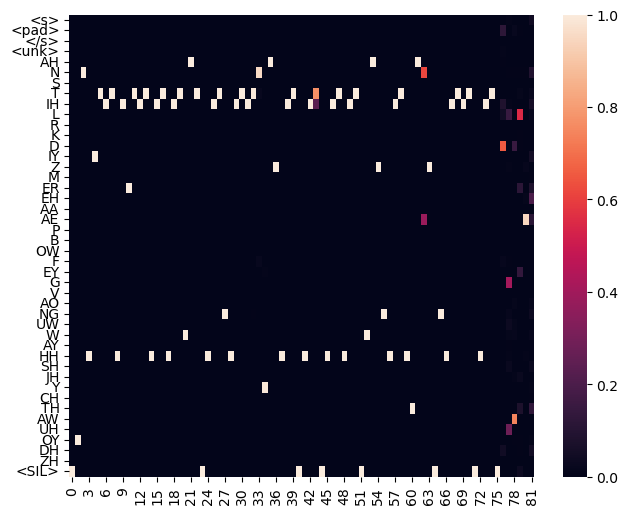

In [30]:
with torch.no_grad():
    posteriograms, padding_mask_post = wav2dyn(features.to(config["device"]), padding_mask.to(config["device"]), random_label.to(config["device"]), dense_x_only=True).values()
    posteriograms = posteriograms[:, :wav2dyn.block_size]
    c_embeddings, c_logits, predictograms, c_entropy = wav2dyn.gen_lm(posteriograms, return_posteriograms=True)
plt.figure(figsize=(7.5, 6))
sns.heatmap(posteriograms[5].T.detach().cpu(), yticklabels=task.target_dictionary.symbols)

In [31]:
idx = 0
utt_len = len(padding_mask[idx]) - padding_mask[idx].sum()
task.target_dictionary.string(posteriograms[idx, :utt_len].argmax(-1))

'<SIL> OY W AH Z HH IH T F Y IH T <SIL> HH IH T IH T HH IH T W IH NG DH EH AW T <SIL> HH IH T <SIL> D <SIL> HH IH T <SIL> JH EY JH Z HH IH T <SIL> AH N T <SIL> HH IH T <SIL> HH NG HH IH T HH IH T IH T HH IH T HH IH T <SIL> UH <unk> R <SIL> D R T B AH D'

In [32]:
idx = 0
utt_len = len(padding_mask[idx]) - padding_mask[idx].sum()
task.target_dictionary.string(predictograms[idx, :utt_len].argmax(-1))

'W L AA N <SIL> IH Z <SIL> AO UW R <SIL> IH IY Z <SIL> NG <SIL> AE Z <SIL> AH DH <SIL> AH M <SIL> <SIL> AH IY Z <SIL> HH AW DH IH M <SIL> DH AH M <SIL> <SIL> IH T <SIL> HH N D IH HH IH T <SIL> HH IH <SIL> IH T <SIL> IH T <SIL> T <SIL> IH T <SIL> IH M <SIL> HH AW <SIL> IH T IH IY IY AY T <SIL>'